<a href="https://colab.research.google.com/github/AyushMaria/Store-Sale-Prediction-using-Time-Series-Data/blob/main/store_sales_s349256_ai_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  My Plan

1. Goal Definition
2. Recognizing the problem
2. Source dataset
3. Which models to use
4. Processing the data
5. Built model(s)
6. Validate the model(s)
7. Test the model(s)
8. Submit the prediction to evaluate the project by the submission score 
9. What I learned
10. What could have been done better?
11. Notes



# 1. Defining the goal

The task is to predict the sales of (thoundsands) of pruducts of an Equadorian shopping mall.

To do that, Kaggle have provided few datasets to be used as a features in the ML trainig dataset.

The data consist of 7 datasets namely:
1. **training.csv** : the training dataset
2. **transaction.csv** : log of the amount of daily 1transaction across all the stores
3. **stores.csv** : every store informations such as area etc.
4. **holiday_events.csv** : list of holiday held in Equador 
5. **oil.csv** : Historical price of crude oil (Equador main economic drive is the oil production)
6. **test.csv** : dataset for testing the model
7. **sample_submission.csv** : example of submission csv format

All the data will be further explored in the data exploration part.

Note: the task also state some additional informations that might be handy later on.
1. Wages in the public sector are paid every two weeks on the 15 th and on the last day of the month. Supermarket sales could be affected by this.
2. A magnitude 7.8 earthquake struck Ecuador on April 16, 2016. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake.


First of all let's take a note about the goal of the competition, which is:
    
### Predict the price of products in the next 15 days from the lastday of the training data.

Let's take a look at test.csv and sample_submission.csv

In [ ]:
from warnings import simplefilter
simplefilter("ignore")  # ignore warnings to clean up output cells

import gc # for garbage cleaning

%config Completer.use_jedi = False # for autocomplete 

In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [ ]:
oil_data = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/oil.csv")
holiday_data = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv")
store_data = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/stores.csv")
train_data = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/train.csv")
test_data = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/test.csv")
transaction_data = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/transactions.csv")
sample = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv')

In [ ]:
test_data.head()

id        date  store_nbr      family  onpromotion
0  3000888  2017-08-16          1  AUTOMOTIVE            0
1  3000889  2017-08-16          1   BABY CARE            0
2  3000890  2017-08-16          1      BEAUTY            2
3  3000891  2017-08-16          1   BEVERAGES           20
4  3000892  2017-08-16          1       BOOKS            0

In [ ]:
sample.head()

id  sales
0  3000888    0.0
1  3000889    0.0
2  3000890    0.0
3  3000891    0.0
4  3000892    0.0

We need to predict the sales on 2017-08-16 to 2017-08-31 for various kind of product and submit with this format.

# 2. Define the problem

Since this is the time series prediction problem, I will utilize the linear regression models to predict the expected sales for each product. However, there are so many features and complimentary datasets. Therefore, additional model might be useful too.


# 3. The data exploration

Here, I planed to explore these areas within all the datasets. In order to get the idea of what might be an interesting features to train the model.

Task:

1. **Total sales** : Hope to see an overall trend or the some spike in sales (perhaps the earthquake would have a big effect.)
2. **Daily sales by each stores** : Hope to see the trend and pattern in sales throughout the timeframe.
3. **Sales by product family, by time** : Hope to see the trend and pattern in sales throughout the timeframe.
4. **Store Location/Cluster Effect on sales** : This might be a good feature in further sale prediction.
5. **Onpromotion effect on sales**
6. **Cycle and Seasonal Effect on total sales** : Hope to see some bi-weekly effect or something interesting.
7. **Map the holiday to the sales record:** I guess that holiday will boost the sales.
8. **Calculate the correlation in change in oil price to change in total sales:** At this point I assume that the fluctuation in oil price won't affect the sales in short term. Since the change in oil price take times to effect the national income and ultimately business activites..
9. **Explore the transaction data** 

In [ ]:
train_data.head()
#seems like the store is close on new year day since they are all 0 sales in 1 Jan.

id        date  store_nbr      family  sales  onpromotion
0   0  2013-01-01          1  AUTOMOTIVE    0.0            0
1   1  2013-01-01          1   BABY CARE    0.0            0
2   2  2013-01-01          1      BEAUTY    0.0            0
3   3  2013-01-01          1   BEVERAGES    0.0            0
4   4  2013-01-01          1       BOOKS    0.0            0

In [ ]:
train_data.info()
#over 3m. lines of data with a date formatted as a string dtype

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


In [ ]:
print('there are {} different product families'.format(train_data.family.nunique()))


there are 33 different product families


In [ ]:
print('there are {} different stores'.format(train_data.store_nbr.nunique()))


there are 54 different stores


train_data consist of several column and over 3 million rows
* id -> will be dropped
* date -> need to format to dt and use as index
* store number -> 1 to 54
* (product) family
* sales (trying to predict this)
* onpromotion. -> gives the total number of items in a product family that were being promoted at a store at a given date

In [ ]:
#let's format the datetime and use as index and drop the id column.
process_train = train_data.copy()

del train_data

process_train['date'] = pd.to_datetime(process_train['date'])
process_train = process_train.set_index('date')
process_train = process_train.drop('id',axis = 1)
process_train[['store_nbr','family']].astype('category') #to reduce ram usage
process_train

store_nbr                      family     sales  onpromotion
date                                                                    
2013-01-01          1                  AUTOMOTIVE     0.000            0
2013-01-01          1                   BABY CARE     0.000            0
2013-01-01          1                      BEAUTY     0.000            0
2013-01-01          1                   BEVERAGES     0.000            0
2013-01-01          1                       BOOKS     0.000            0
...               ...                         ...       ...          ...
2017-08-15          9                     POULTRY   438.133            0
2017-08-15          9              PREPARED FOODS   154.553            1
2017-08-15          9                     PRODUCE  2419.729          148
2017-08-15          9  SCHOOL AND OFFICE SUPPLIES   121.000            8
2017-08-15          9                     SEAFOOD    16.000            0

[3000888 rows x 4 columns]

let's check the possible missing data / observation.

In [ ]:
process_train.isna().sum()

store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

check the missing date (missing the entire observation).

Let's begin by checking the time-lag between each observation.

In [ ]:
def count_day_gap(df):
    temp = df.reset_index().groupby(['date']).sales.sum()
    return (temp.index[1:]-temp.index[:-1]).value_counts()

In [ ]:
count_day_gap(process_train)

1 days    1679
2 days       4
Name: date, dtype: int64

4 rows of the data are missing as we see that the 2 days time-gap are presented 4 time. Where are thay?

In [ ]:
temp = process_train.reset_index().groupby(['date']).sales.sum().to_frame()
gap = (temp.index[1:]-temp.index[:-1]).to_list()
gap.insert(0,'first day') #add to gap list to have the same length as temp to combine it together
temp['gap'] = gap
#print(temp.gap.unique())

day_skip = temp.groupby('gap').get_group(temp.gap.unique()[2])
day_skip

sales              gap
date                                     
2013-12-26  4.707312e+05  2 days 00:00:00
2014-12-26  8.720985e+05  2 days 00:00:00
2015-12-26  9.467252e+05  2 days 00:00:00
2016-12-26  1.032771e+06  2 days 00:00:00

In [ ]:
del temp

2013 - 2014 - 2015 -2016 Christmas days (20xx-12-25) are all missing. 

Let's see if there are other days that the total sales across country is zero. 

In [ ]:
process_train.groupby('date').sales.sum().sort_values().head(10)

date
2013-01-01      2511.618999
2014-01-01      8602.065404
2017-01-01     12082.500997
2015-01-01     12773.616980
2016-01-01     16433.394000
2013-01-24    247245.690995
2013-03-14    247541.420096
2013-01-10    258982.003049
2013-01-29    264488.818076
2013-06-27    266525.458966
Name: sales, dtype: float64

Besides Christmas day, there are no other day that have zero sales. The Christmas will be add back in the holiday EDA section.


### Let's see a total sales combined

First of all, let's see total sales as a stackpolot. I could get the idea of what's selling well and the major trend of total sales. Also, I will mark the earthquake to see if the quake noticably affect the sales.

In [ ]:
date_fam_sale = process_train.groupby(['date','family']).sum().sales
unstack = date_fam_sale.unstack()
unstack = unstack.resample('1M').sum()

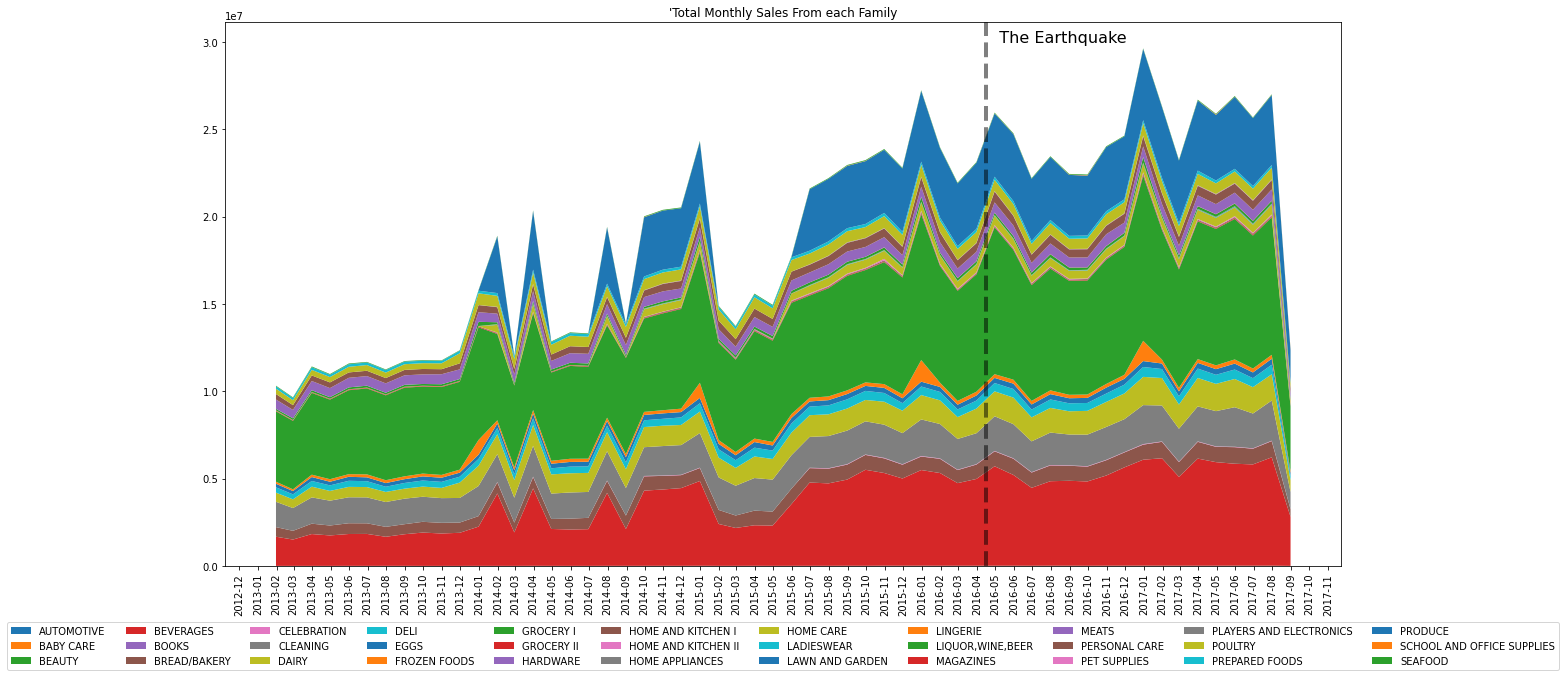

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.set(title="'Total Monthly Sales From each Family")
plt.stackplot(unstack.index,unstack.T,labels=unstack.T.index)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.axvline(x=pd.Timestamp('2016-04-16'),color='black',linestyle='--',linewidth=4,alpha=0.5)
plt.text(pd.Timestamp('2016-04-20'),30000000,'  The Earthquake',rotation=360,c='black',size=16)
plt.xticks(rotation=90)
plt.legend(loc='lower center',bbox_to_anchor=(0.5,-0.2),ncol=11)
plt.show()

In [ ]:
del unstack
del date_fam_sale

**Interpretation:** The stackplot shows that only few product families accounted for a majority of sales. And the earthquake may cause a spike in sales for a short while. The steep drop at the end of the data is caused by the 2017-08 data that has been given from 2017-08-1 to 2017-08-15. So the drop is assosiated with the missing of the other half month.

The color is still confusing. Let's do the barchart to rank the product which are sold the most.

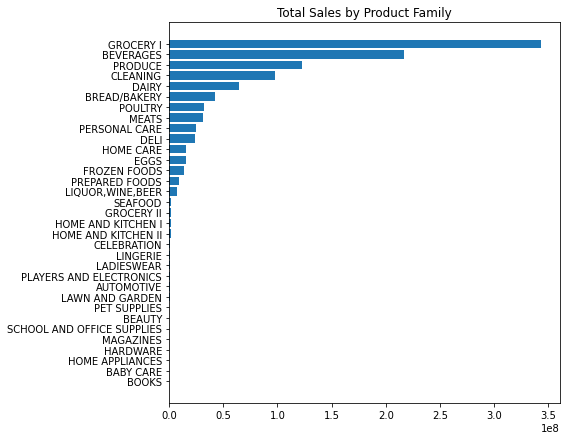

In [ ]:
month_family = process_train.groupby('family').resample('M').sales.sum() #resample to monthly sales 

fig, ax = plt.subplots(figsize=(7,7))
plt.barh(month_family.groupby('family').sum().sort_values().index,month_family.groupby('family').sum().sort_values())
ax.set(title='Total Sales by Product Family')
plt.show()


let's calculte the proportaion of sales by category


In [ ]:
total_sale = month_family.sum()
family_sale = month_family.groupby('family').sum().sort_values()
proportion = ((family_sale/total_sale)*100).sort_values(ascending=False)
proportion = pd.DataFrame(proportion)
proportion.head()

sales
family              
GROCERY I  31.990346
BEVERAGES  20.207284
PRODUCE    11.428795
CLEANING    9.083197
DAIRY       6.006428

In [ ]:
del family_sale

The product families which accounted for the most sales are
1. GROCERY I - 31.99%
2. BEVERAGES - 20.21%
3. PRODUCE - 11.43%
4. CLEANING - 9.08%
5. DAIRY - 6%

Just for the top five, they have accounted for more than 75% of total sales already.

Let's take a look at daily total sales.

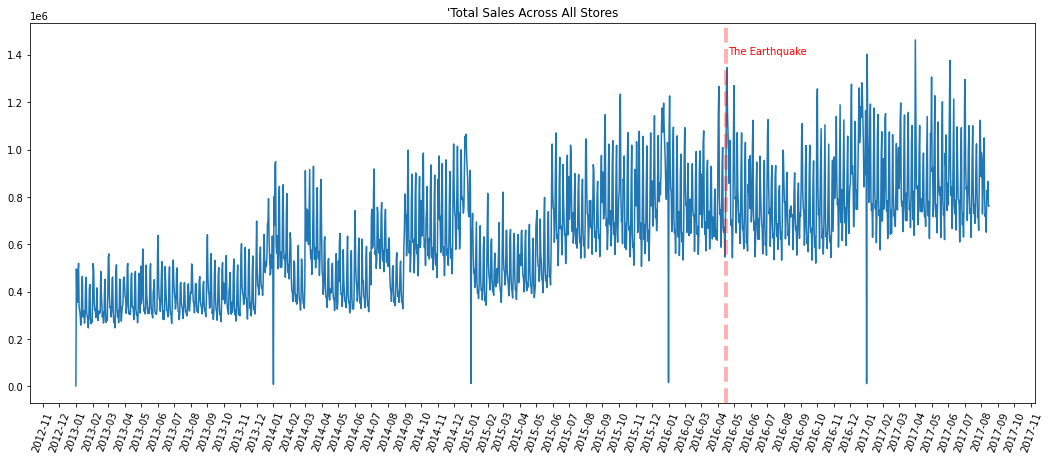

In [ ]:
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(18, 7))
ax.set(title="'Total Sales Across All Stores")
total_sales = process_train.sales.groupby("date").sum()
plt.plot(total_sales)

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.xticks(rotation=70)
plt.axvline(x=pd.Timestamp('2016-04-16'),color='r',linestyle='--',linewidth=4,alpha=0.3)
plt.text(pd.Timestamp('2016-04-20'),1400000,'The Earthquake',rotation=360,c='r')


plt.show()

**Interpretation:** Overall, I see an uptrend in total sales across the country since 2013. Let's check why there are those super deep valleys near many year's end. My guess now is that all the shop are closed at the New Year or New Year Eve for holiday so there is no sales. I will reconfirm this again at the holiday analyses.

Noted that the earthquake marked with the red dotted band seems to boost the sales few days after.

### Let's plot each store sale by date

In [ ]:
#create a dic that contain each store total daily sale.
daily_sale_dict = {}
for i in process_train.store_nbr.unique():
    daily_sale = process_train[process_train['store_nbr']==i]
    daily_sale_dict[i] = daily_sale

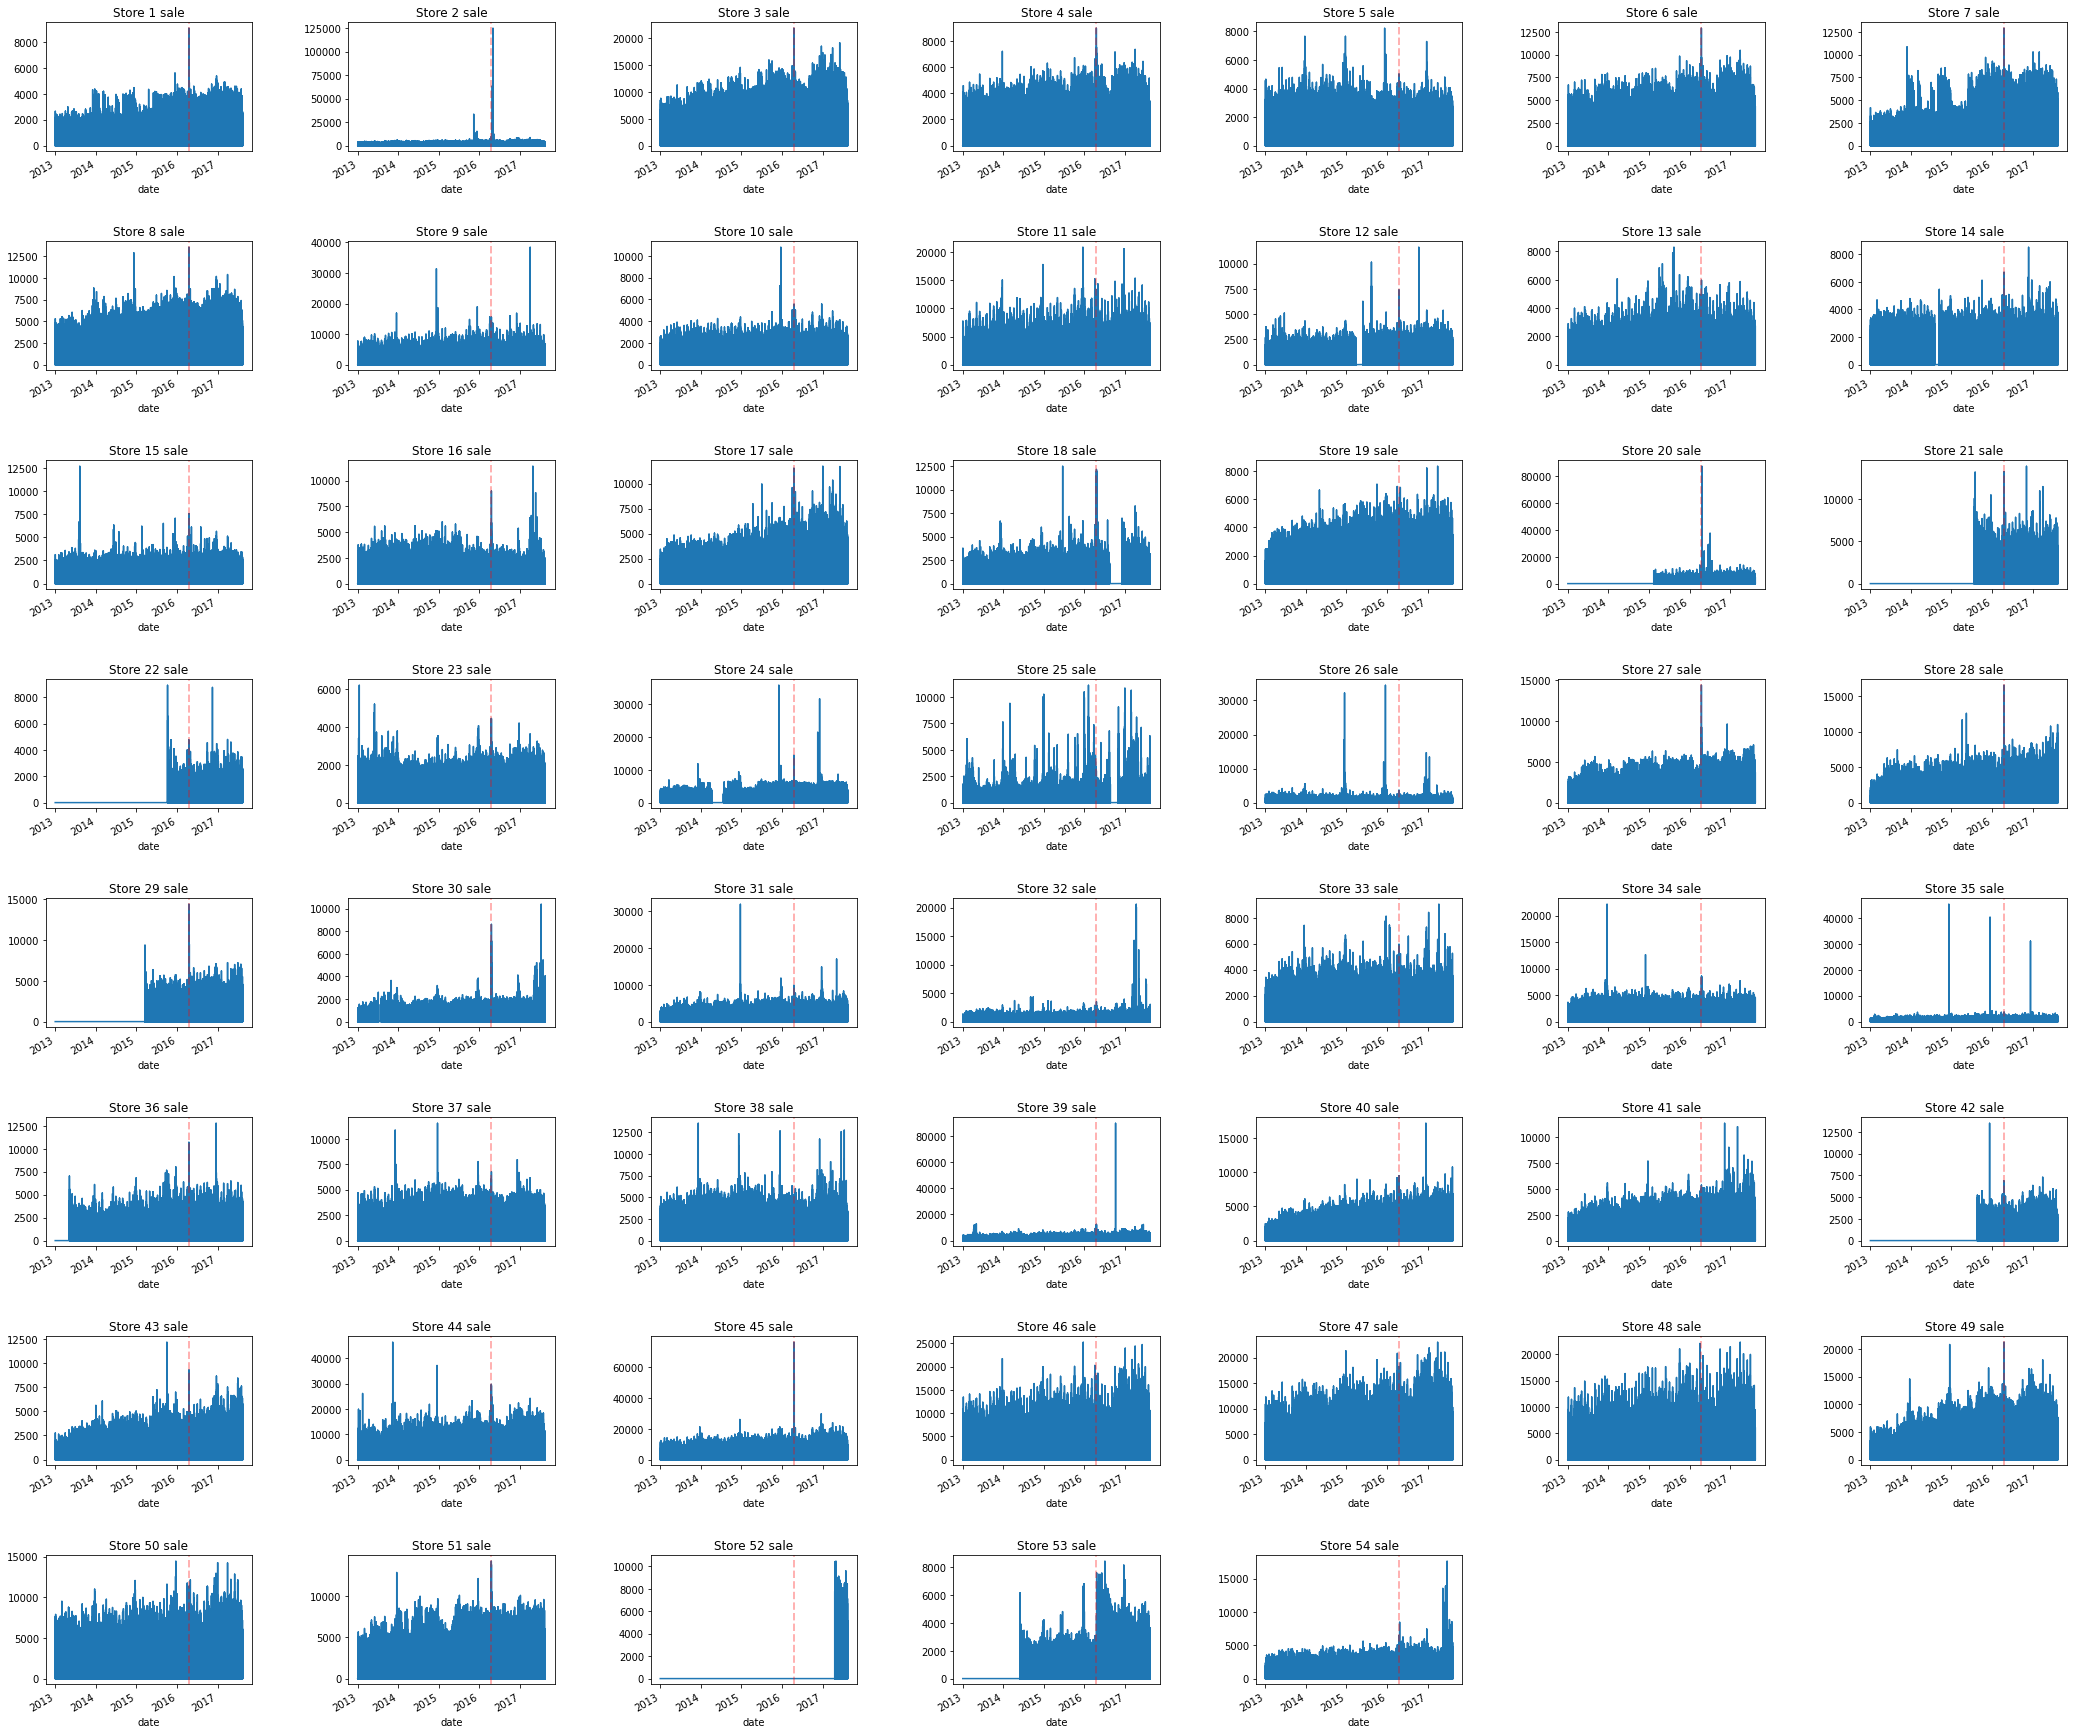

In [ ]:
fig = plt.figure(figsize=(30,30))
for i in daily_sale_dict.keys():
    plt.subplot(8,7,i)
    plt.title('Store {} sale'.format(i))
    plt.tight_layout(pad=5)
    sale = daily_sale_dict[i].sales
    sale.plot()
    plt.axvline(x=pd.Timestamp('2016-04-16'),color='r',linestyle='--',linewidth=2,alpha=0.3) #mark the earthquake

**Interpretation:** There are so many "gaps" or "white space" in some stores sales record. I guess they are from either temporary store close or the store not yet operate. 

One thing to note is that, from times to times, there will be a sharp spike in sales (ex. store # 35 which had 3 spikes around the year's end of 2014, 2015, 2016. This may need futher scrutinization.

Considering the earthquake, it affected the sales variedly from store to store. Some store such as 18,20,21,etc.. saw a great one time spike. Some store such as store 5,26,35,etc.. didn't have any huge sales changes. However, for store 53, it's the gamechanger. Store 53 had gone through a long duration of sale increase for years.

The main theme here is that, on average, store sales are in uptrend since 2013.

### What about the sales by Product Family.

In [ ]:
by_fam_dic = {}
fam_list = process_train.family.unique()

for fam in fam_list:
    by_fam_dic[fam] = process_train[process_train['family']==fam].sales

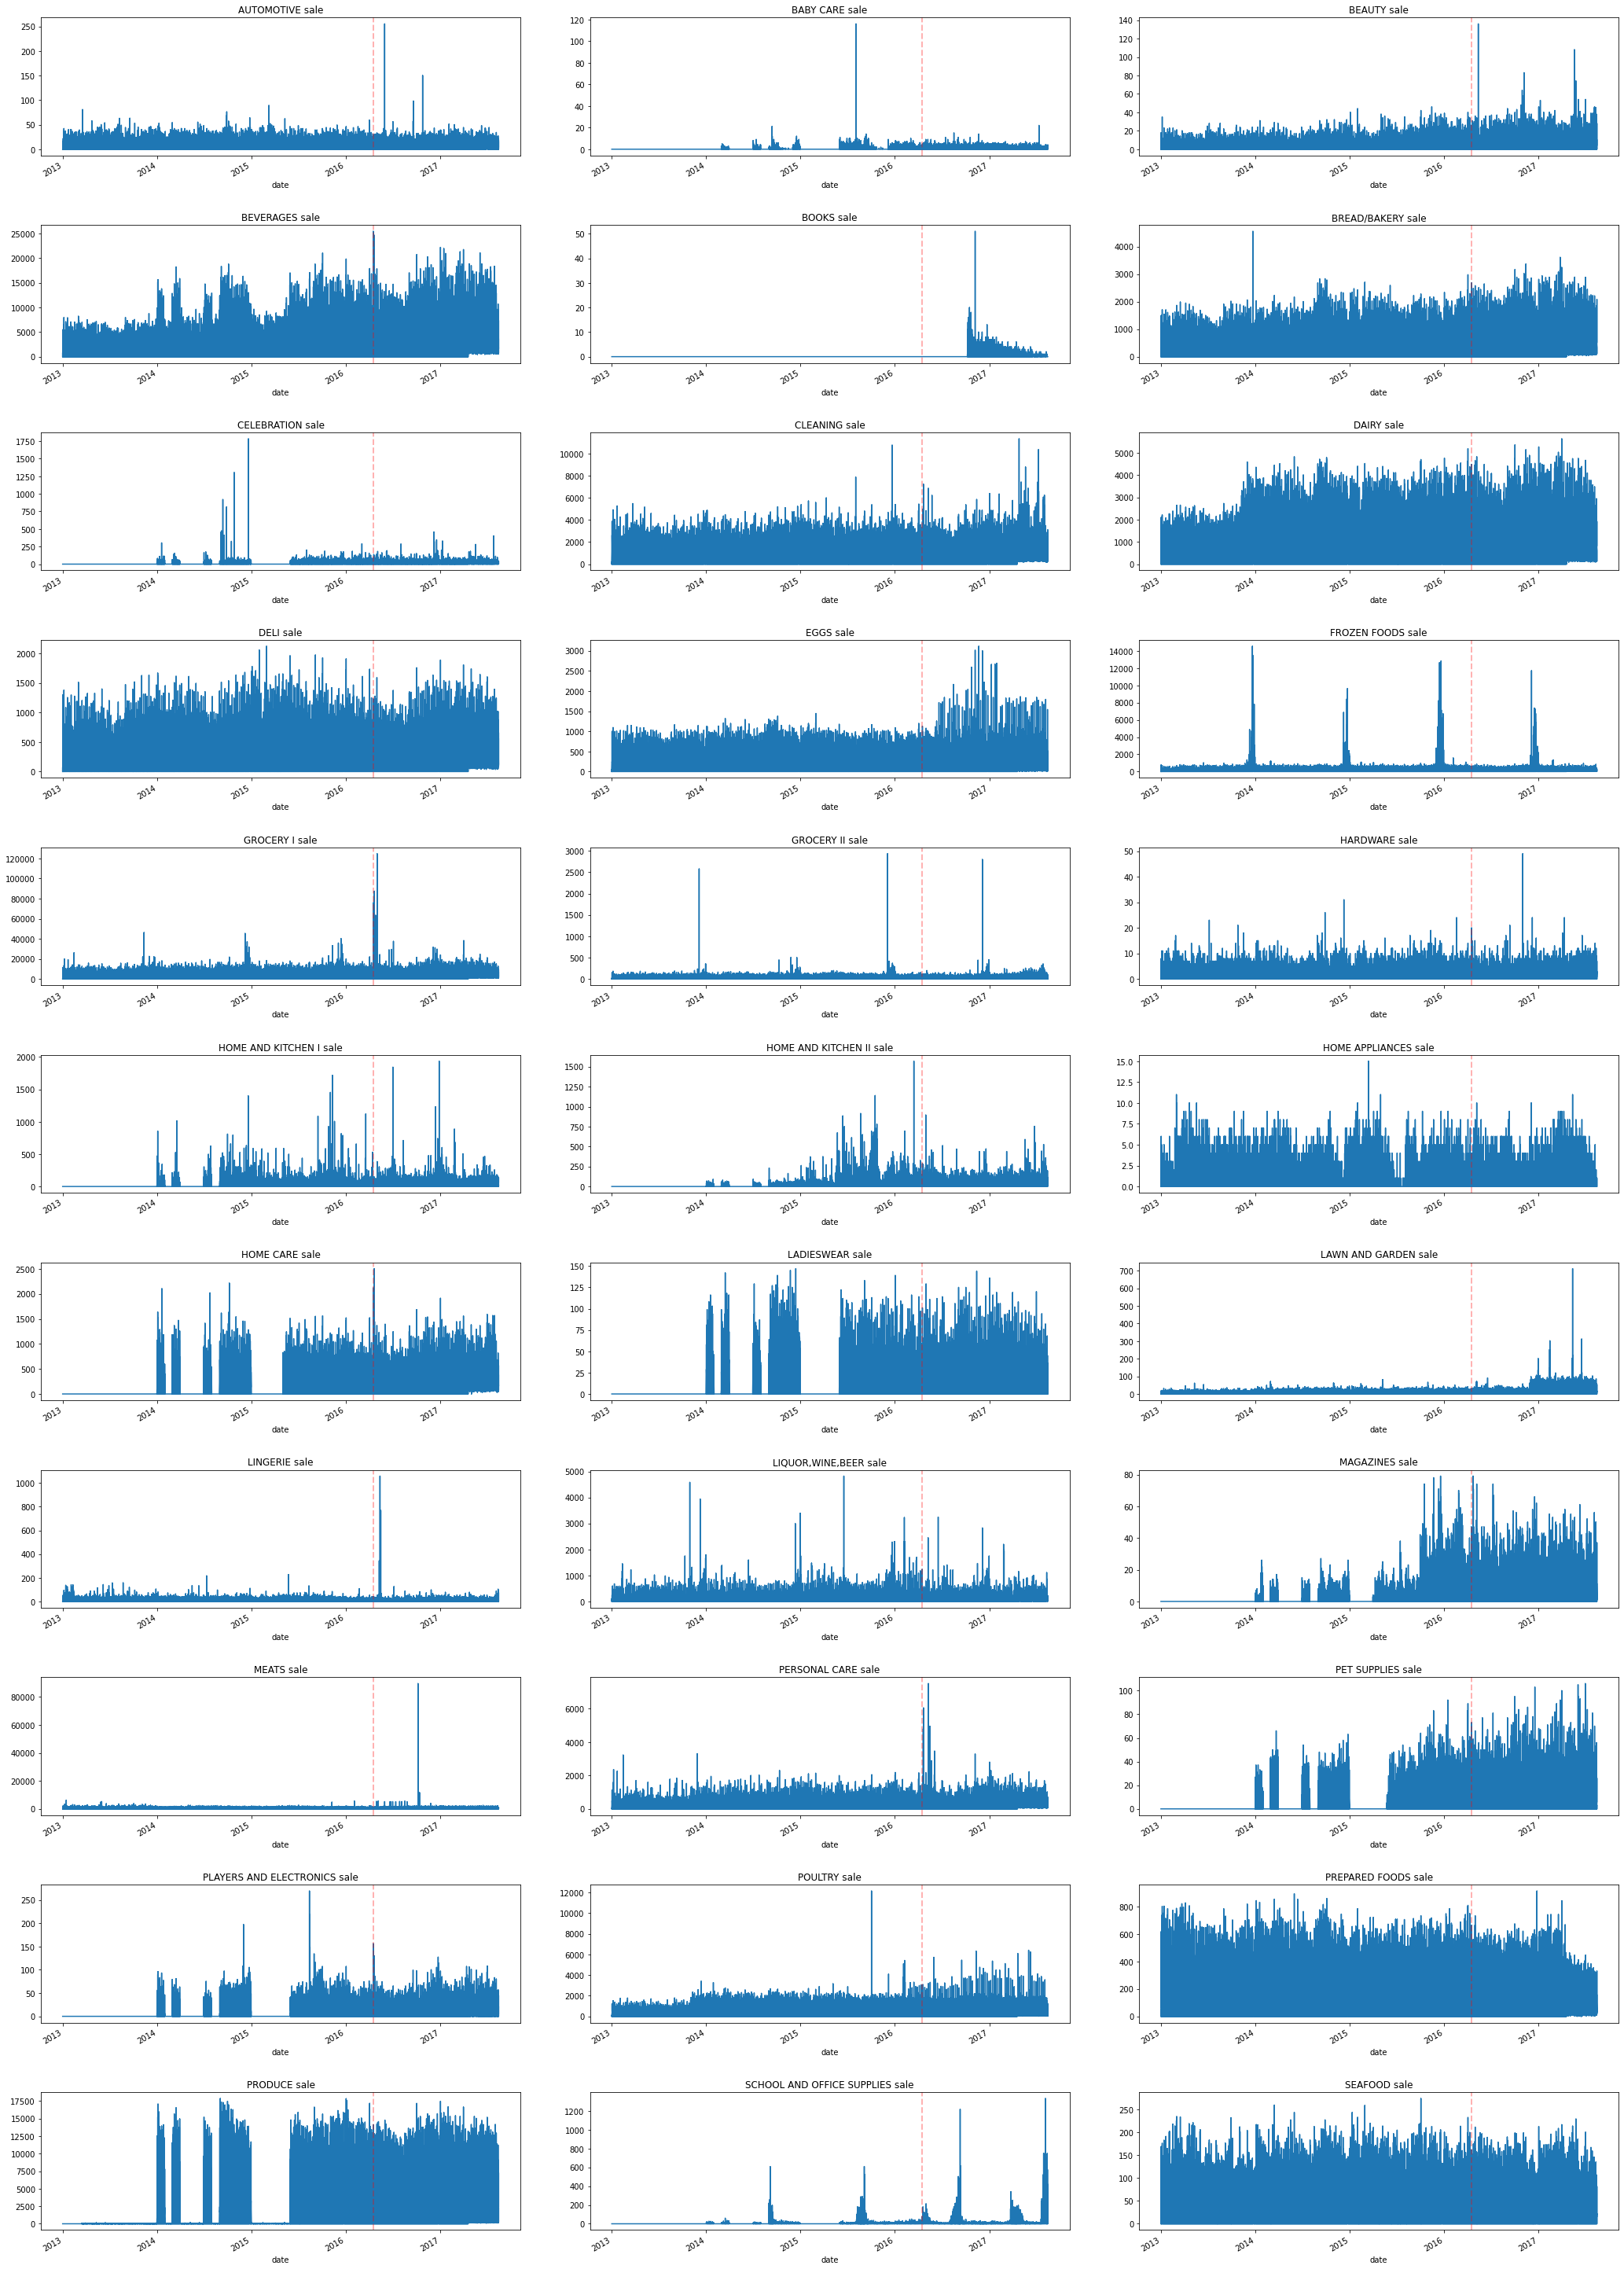

In [ ]:
fig = plt.figure(figsize=(30,50))

for i,fam in enumerate(by_fam_dic.keys()):
    plt.subplot(11,3,i+1)
    plt.title('{} sale'.format(fam))
    plt.tight_layout(pad=5)
    sale = by_fam_dic[fam]
    sale.plot()
    plt.axvline(x=pd.Timestamp('2016-04-16'),color='r',linestyle='--',linewidth=2,alpha=0.3) #mark the earthquake


**Interpretation:** Each family has their own selling paterns. However, Frozen Food and School and Office Supplies shown highly seasonal cycle.
* Frozen Food : Sell more on New Year
* School and Office Supplies: Sale more around AUG

In [ ]:
del by_fam_dic
del fam_list

### What about the stores themselves.

The competition data description explicitly describe that "cluster is a grouping of similar store". This might explan some of the different sales patterns in the subplots above. Let's see what can I get from this.

In [ ]:
store_data.head(3)

store_nbr   city      state type  cluster
0          1  Quito  Pichincha    D       13
1          2  Quito  Pichincha    D       13
2          3  Quito  Pichincha    D        8

In [ ]:
#add the cluster to the process_train df
join_df = process_train.merge(store_data,on='store_nbr')

#get the missing time after merge back in place
join_df.set_index(process_train.index)
join_df['date'] = process_train.index
join_df = join_df.set_index('date')

join_df.head()

store_nbr      family  sales  onpromotion   city      state type  \
date                                                                           
2013-01-01          1  AUTOMOTIVE    0.0            0  Quito  Pichincha    D   
2013-01-01          1   BABY CARE    0.0            0  Quito  Pichincha    D   
2013-01-01          1      BEAUTY    0.0            0  Quito  Pichincha    D   
2013-01-01          1   BEVERAGES    0.0            0  Quito  Pichincha    D   
2013-01-01          1       BOOKS    0.0            0  Quito  Pichincha    D   

            cluster  
date                 
2013-01-01       13  
2013-01-01       13  
2013-01-01       13  
2013-01-01       13  
2013-01-01       13

I'm curious about the store_data Let's compare the average sales between types and alo between cluster. Hopefully I can see some pattern. 

In [ ]:
 def show_type_df(join_store_type_df):
    mean_sales_type = join_store_type_df.groupby('type').sales.mean()
    median_sales_type = join_store_type_df.groupby('type').sales.median()
    number=join_store_type_df.groupby('type').store_nbr.nunique()

    type_df = pd.DataFrame((mean_sales_type,median_sales_type,number))
    type_df = type_df.T
    type_df.columns = ['mean','median','number of store']

    return type_df

In [ ]:
show_type_df(join_df)

mean  median  number of store
type                                     
A     705.878743    24.0              9.0
B     326.739714     7.0              8.0
C     197.263301     5.0             15.0
D     350.979407    16.0             18.0
E     269.121301     4.0              4.0

Although type C and D are most common store type, but the biggest individual performance of the sales came from type A and D. In fact, type C is the worst proforming store in term of sales.

### What about the store cluster.

In [ ]:
def show_cluster_summary(join_store_type_df):
    mean_sales_cluster = join_store_type_df.groupby('cluster').sales.mean()
    median_sales_cluster = join_store_type_df.groupby('cluster').sales.median()
    number=join_store_type_df.groupby('cluster').store_nbr.nunique()

    cluster_df = pd.DataFrame((mean_sales_cluster,median_sales_cluster,number))
    cluster_df = cluster_df.T
    cluster_df.columns = ['mean','median','number of store']

    return cluster_df.sort_values('mean', ascending=False)

In [ ]:
show_cluster_summary(join_df)

mean  median  number of store
cluster                                      
5        1117.245254    75.0              1.0
14        708.227718    36.0              4.0
8         647.377856    42.0              3.0
11        603.507018     5.0              3.0
17        592.231511    27.0              1.0
6         342.661732     7.0              6.0
1         326.163967    15.0              3.0
12        324.461406    10.0              1.0
13        324.364108    14.0              4.0
4         296.572872    19.0              3.0
9         274.968339    16.0              2.0
2         260.170621     5.0              2.0
10        255.897546     5.0              6.0
16        238.598137     8.0              1.0
15        199.010111     7.0              5.0
3         194.416262     6.0              7.0
7         139.261863     0.0              2.0

Cluster #5 is unique. It has only 1 store but contribute to the biggest individual cluster sales. The other's are as the dataframe states. I'm not sure if cluster will be a reall good featues since the sales are not really distictive except the #5. We reconfirm this thought see in the model later.

### let's see the City characteristic



In [ ]:
def show_city_df(join_store_type_df):    
    mean_sales_city = join_store_type_df.groupby('city').sales.mean()
    median_sales_city = join_store_type_df.groupby('city').sales.median()
    number=join_store_type_df.groupby('city').store_nbr.nunique()

    city_df = pd.DataFrame((mean_sales_city,median_sales_city,number))
    city_df = city_df.T
    city_df.columns = ['mean','median','number of store']

    return city_df.sort_values('mean', ascending=False)

In [ ]:
show_city_df(join_df)

mean  median  number of store
city                                              
Quito          556.577090    24.0             18.0
Cayambe        509.709179    15.0              1.0
Ambato         362.632273    21.0              2.0
Daule          345.282181    18.0              1.0
Loja           339.379530    22.0              1.0
Babahoyo       319.349181    10.0              1.0
Machala        300.392253    13.0              2.0
Esmeraldas     294.963151     7.0              1.0
Cuenca         294.924279     8.0              3.0
Guayaquil      276.594464     7.0              8.0
Libertad       275.722146     5.0              1.0
Quevedo        255.137503     9.0              1.0
Guaranda       234.821670     8.0              1.0
Santo Domingo  214.942315     5.0              3.0
Ibarra         206.061866     8.0              1.0
Salinas        205.517129     9.0              1.0
Riobamba       204.921881     6.0              1.0
El Carmen      198.975799     6.0              1.0
Latacunga      190.583961     6.0              2.0
Playas         138.139340     3.0              1.0
Manta          125.173982     0.0              2.0
Puyo            73.601845     0.0              1.0

In [ ]:
del join_df

This looks really interesting. Quito seem to be the main operating city for our chain store and accounted for the most product sales across the country.

Last thing I'd like to explore within stores is a heatmap coorelation between the sales pattern of each stores.

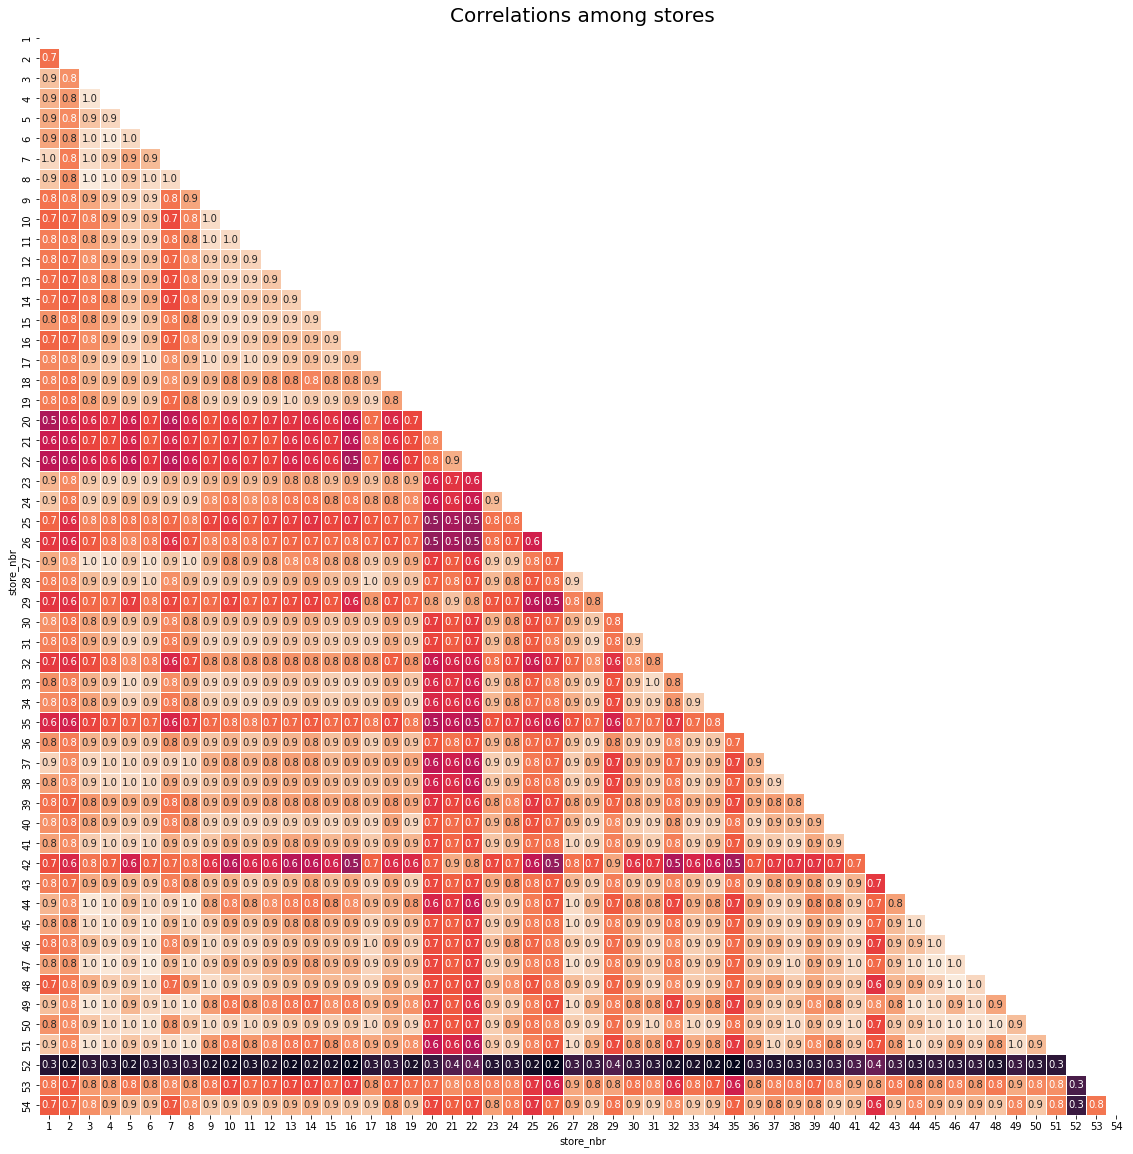

In [ ]:
import seaborn as sns

a = process_train[["store_nbr", "sales"]] #slice only the two columns
a["ind"] = 1 # create a column of ones

#cumulate the 1 column til the last observation. Ultimately, count the lines for a store.
a["ind"] = a.groupby("store_nbr").ind.cumsum().values 

#create a corelation pivot table between sales of each stores
a = pd.pivot(a, index = "ind", columns = "store_nbr", values = "sales").corr() 

mask = np.triu(a.corr()) # slice the top triangle of the a.corr() dataFrame

plt.figure(figsize=(20, 20))
sns.heatmap(a,
         annot=True,
         fmt='.1f',
         square=True,
         mask=mask,
         linewidths=1,
         cbar=False)
plt.title("Correlations among stores",fontsize = 20)
plt.show()

#ref: https://www.kaggle.com/ekrembayar/store-sales-ts-forecasting-a-comprehensive-guide/notebook

In [ ]:
del a
del mask

In [ ]:
gc.collect()

95981

All the store sales seems to go together except the store number 52. 

But.... scrolling up to the grid of store sales above (just ctrl+f "Let's plot each store sale by date"). 
Store 52 is just a newly opened store. and has almost no sales record compared to the others. 

In fact, all the dark cell contain lower corelation from store 20,21,22,42,52 are stores that are newly operated compared to the others.

let's check the first entry of store 20 to make sure.

In [ ]:
store_20 = process_train.groupby(['store_nbr','date']).sales.sum().loc[20]
store_20.loc['2013-01-01':'2015-01-01']

date
2013-01-01    0.0
2013-01-02    0.0
2013-01-03    0.0
2013-01-04    0.0
2013-01-05    0.0
             ... 
2014-12-28    0.0
2014-12-29    0.0
2014-12-30    0.0
2014-12-31    0.0
2015-01-01    0.0
Name: sales, Length: 729, dtype: float64

In [ ]:
del store_20

really no sales at all

### Effect of promotion

the competition overview state that the **onpromotion** column "gives the total number of items in a product family that were being promoted at a store at a given date."

let's take a look with the corelation between onpromotion and sales.

In [ ]:
print('Spearman Rank Correlation = {}'.format(
    process_train.sales.corr(process_train.onpromotion,method='spearman')))

Spearman Rank Correlation = 0.5380218163559225


There is correlation between promotion and sales of certain family of product.

The reason I chose Spearman rank correlation here is because the default (Pearson's) correlation needs the distribution of both variable to be normal distributed. While the promotion itself is defined by the marketing plan.

### Let's explopre trend, seasonal, and cycles

Just for simplicity of the first attempt, I did not use any determininstic process or Fourier series to determine the cycle of the sales. Instead, I used the rolling window average to project a trend and used as a feature for trend.

As for the cycle, I don't think I can overlook this feature since the days of the week (or month of year) are crucial in retail business. I used one-hot encoding for and feed as a feature.

First, let's make sure that the seasonal effect exist.

In [ ]:
from datetime import datetime as dt

def show_dow_sales():
    day_group = process_train.reset_index()[['date','sales']]
    day_group = day_group.groupby('date')
    day_group = day_group.sales.mean().to_frame()
    day_group['dow'] = day_group.index.day_of_week
    day_group = day_group.groupby('dow').sum()
    plt.bar(day_group.index,day_group['sales'])
    plt.title('Average sales on day of week')
    plt.show()

In [ ]:
def show_month_group_sale():
    month_group = process_train['sales'].to_frame()
    month_group['moy'] = month_group.index.month
    month_group = month_group.groupby('moy').sales.mean().to_frame()
    plt.bar(month_group.index,month_group['sales'])
    plt.title('Average sales on Month of Year')
    plt.show()

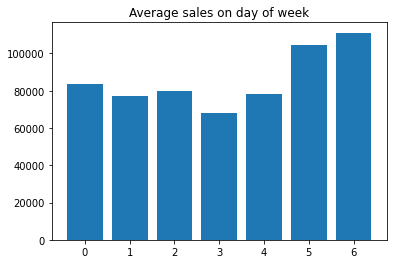

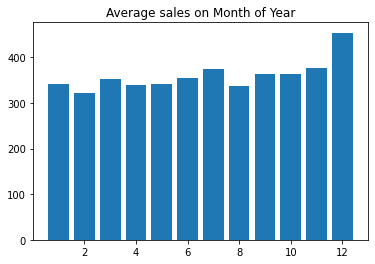

In [ ]:
show_dow_sales()
show_month_group_sale()

On average, business is good in the weekends and quarter 4.

After extracting some basic seasonality, let's explore the effect of holiday.

### Holiday Effect on sales

* NOTE: Pay special attention to the transferred column. A holiday that is transferred officially falls on that calendar day, but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for the corresponding row where type is Transfer. For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.
* Additional holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday). 

In [ ]:
holiday_data = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv",index_col='date',parse_dates=['date'])
holiday_data

type    locale locale_name                    description  \
date                                                                          
2012-03-02     Holiday     Local       Manta             Fundacion de Manta   
2012-04-01     Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
2012-04-12     Holiday     Local      Cuenca            Fundacion de Cuenca   
2012-04-14     Holiday     Local    Libertad      Cantonizacion de Libertad   
2012-04-21     Holiday     Local    Riobamba      Cantonizacion de Riobamba   
...                ...       ...         ...                            ...   
2017-12-22  Additional  National     Ecuador                      Navidad-3   
2017-12-23  Additional  National     Ecuador                      Navidad-2   
2017-12-24  Additional  National     Ecuador                      Navidad-1   
2017-12-25     Holiday  National     Ecuador                        Navidad   
2017-12-26  Additional  National     Ecuador                      Navidad+1   

            transferred  
date                     
2012-03-02        False  
2012-04-01        False  
2012-04-12        False  
2012-04-14        False  
2012-04-21        False  
...                 ...  
2017-12-22        False  
2017-12-23        False  
2017-12-24        False  
2017-12-25        False  
2017-12-26        False  

[350 rows x 5 columns]

Let's check if Quito (the main operating area) is here 

In [ ]:
holiday_data.locale_name.value_counts().head()

Ecuador      174
Quito         13
Riobamba      12
Guaranda      12
Latacunga     12
Name: locale_name, dtype: int64

Quito is here and it has the most regional holidays. 

Didn't see New Year and Christmas day in the holiday_data. This day is so impactful since the sales across the counrty is dropped to about zero. Let's add it back.

In [ ]:
ny_dic = {'type': 'Holiday','locale':'National','locale_name':'Ecuador','description': 'New Year Day','transferred':'False'}
ny_date = pd.to_datetime(['2012-01-01','2013-01-01','2014-01-01','2015-01-01','2016-01-01','2017-01-01','2018-01-01'])

cm_dic = {'type': 'Holiday','locale':'National','locale_name':'Ecuador','description': 'Christmas Day','transferred':'False'}
cm_date = pd.to_datetime(['2012-12-25','2013-12-25','2014-12-25','2015-12-25','2016-12-25','2017-12-25','2018-12-25'])

In [ ]:
for date in ny_date:
    holiday_data.loc[date] = ['Holiday','National', 'Ecuador', 'New Year day','False']
    
for date in cm_date:
    holiday_data.loc[date] = ['Holiday','National', 'Ecuador', 'Christmas day','False']

In [ ]:
holiday_data = holiday_data.sort_index()

From taking a look at the holiday df above, I think there are someting need formatting.
* Group Football Events(They might have the different effect from other ceremonial event.
* Deal with transfered events
* Emphasize Cyber Monday and Black Friday (Since these are practically shopping day.)
* Creat a dummy DF that contain the 
    * date 
    * type of event (one-hot)
        * is_football
        * is_Earthquake
        * is_shopping_event
        * other events
    * where the event was held (one-hot)
        * Other dummy columns for the location
    * work day or not


In [ ]:
calendar = pd.DataFrame(index = pd.date_range('2013-01-01','2017-08-31'))
calendar = calendar.join(holiday_data).fillna(0)
del holiday_data
calendar

type    locale locale_name              description  \
2013-01-01   Holiday  National     Ecuador             New Year day   
2013-01-02         0         0           0                        0   
2013-01-03         0         0           0                        0   
2013-01-04         0         0           0                        0   
2013-01-05  Work Day  National     Ecuador  Recupero puente Navidad   
...              ...       ...         ...                      ...   
2017-08-27         0         0           0                        0   
2017-08-28         0         0           0                        0   
2017-08-29         0         0           0                        0   
2017-08-30         0         0           0                        0   
2017-08-31         0         0           0                        0   

           transferred  
2013-01-01       False  
2013-01-02           0  
2013-01-03           0  
2013-01-04           0  
2013-01-05       False  
...                ...  
2017-08-27           0  
2017-08-28           0  
2017-08-29           0  
2017-08-30           0  
2017-08-31           0  

[1734 rows x 5 columns]

In [ ]:
calendar['dow'] = calendar.index.dayofweek+1
calendar['workday'] = True
calendar.loc[calendar['dow']>5 , 'workday'] = False #make work_day false for sat and sun (6/7 in dow)

calendar.head()

type    locale locale_name              description  \
2013-01-01   Holiday  National     Ecuador             New Year day   
2013-01-02         0         0           0                        0   
2013-01-03         0         0           0                        0   
2013-01-04         0         0           0                        0   
2013-01-05  Work Day  National     Ecuador  Recupero puente Navidad   

           transferred  dow  workday  
2013-01-01       False    2     True  
2013-01-02           0    3     True  
2013-01-03           0    4     True  
2013-01-04           0    5     True  
2013-01-05       False    6    False

Next, I'm setting workday in each **National** Holiday to ba False no matter dayofweek. Local holiday maybe a normal working day for the nation.

In [ ]:
calendar.loc[(calendar['type']=='Holiday') & (calendar['locale'].str.contains('National')), 'workday'] = False
calendar.loc[(calendar['type']=='Additional') & (calendar['locale'].str.contains('National')), 'workday'] = False
calendar.loc[(calendar['type']=='Bridge') & (calendar['locale'].str.contains('National')), 'workday'] = False
calendar.loc[(calendar['type']=='Transfer') & (calendar['locale'].str.contains('National')), 'workday'] = False

#some holiday are explicitly said it is workday
calendar.loc[calendar['type']=='Work Day' , 'workday'] = True

Let's check the transfered holiday. They supposed to become working day if they are not Sat and Sun. Let's see that.

In [ ]:
calendar.where(calendar['transferred'] == True).dropna()

type    locale locale_name                    description  \
2013-10-09  Holiday  National     Ecuador     Independencia de Guayaquil   
2014-10-09  Holiday  National     Ecuador     Independencia de Guayaquil   
2016-05-24  Holiday  National     Ecuador           Batalla de Pichincha   
2016-07-25  Holiday     Local   Guayaquil         Fundacion de Guayaquil   
2016-08-10  Holiday  National     Ecuador  Primer Grito de Independencia   
2017-04-12  Holiday     Local      Cuenca            Fundacion de Cuenca   
2017-05-24  Holiday  National     Ecuador           Batalla de Pichincha   
2017-08-10  Holiday  National     Ecuador  Primer Grito de Independencia   

           transferred  dow workday  
2013-10-09        True  3.0   False  
2014-10-09        True  4.0   False  
2016-05-24        True  2.0   False  
2016-07-25        True  1.0    True  
2016-08-10        True  3.0   False  
2017-04-12        True  3.0    True  
2017-05-24        True  3.0   False  
2017-08-10        True  4.0   False

They are all weekday (since 'dow' are all less than 5). Therefore, format the work_day to True

In [ ]:
calendar.loc[(calendar['transferred'] == True), 'workday'] = True

Format the football to be the one same kind of event. Do the same for the earthquake that last multiple days.

In [ ]:
calendar.where(calendar['description'].str.contains('futbol')).dropna()

type    locale locale_name  \
2014-06-12  Event  National     Ecuador   
2014-06-15  Event  National     Ecuador   
2014-06-20  Event  National     Ecuador   
2014-06-25  Event  National     Ecuador   
2014-06-28  Event  National     Ecuador   
2014-06-29  Event  National     Ecuador   
2014-06-30  Event  National     Ecuador   
2014-07-01  Event  National     Ecuador   
2014-07-04  Event  National     Ecuador   
2014-07-05  Event  National     Ecuador   
2014-07-08  Event  National     Ecuador   
2014-07-09  Event  National     Ecuador   
2014-07-12  Event  National     Ecuador   
2014-07-13  Event  National     Ecuador   

                                                description transferred  dow  \
2014-06-12            Inauguracion Mundial de futbol Brasil       False  4.0   
2014-06-15          Mundial de futbol Brasil: Ecuador-Suiza       False  7.0   
2014-06-20       Mundial de futbol Brasil: Ecuador-Honduras       False  5.0   
2014-06-25        Mundial de futbol Brasil: Ecuador-Francia       False  3.0   
2014-06-28       Mundial de futbol Brasil: Octavos de Final       False  6.0   
2014-06-29       Mundial de futbol Brasil: Octavos de Final       False  7.0   
2014-06-30       Mundial de futbol Brasil: Octavos de Final       False  1.0   
2014-07-01       Mundial de futbol Brasil: Octavos de Final       False  2.0   
2014-07-04       Mundial de futbol Brasil: Cuartos de Final       False  5.0   
2014-07-05       Mundial de futbol Brasil: Cuartos de Final       False  6.0   
2014-07-08            Mundial de futbol Brasil: Semifinales       False  2.0   
2014-07-09            Mundial de futbol Brasil: Semifinales       False  3.0   
2014-07-12  Mundial de futbol Brasil: Tercer y cuarto lugar       False  6.0   
2014-07-13                  Mundial de futbol Brasil: Final       False  7.0   

           workday  
2014-06-12    True  
2014-06-15   False  
2014-06-20    True  
2014-06-25    True  
2014-06-28   False  
2014-06-29   False  
2014-06-30    True  
2014-07-01    True  
2014-07-04    True  
2014-07-05   False  
2014-07-08    True  
2014-07-09    True  
2014-07-12   False  
2014-07-13   False

In [ ]:
calendar['is_football'] = 0
calendar['is_eq'] = 0

calendar.loc[(calendar['is_football'] == 0) & (calendar['description'].str.contains('futbol')), 'is_football'] = 1
calendar.loc[(calendar['is_eq'] == 0) & (calendar['description'].str.contains('Terremoto')), 'is_eq'] = 1

In [ ]:
calendar.where(calendar['is_football']==1).dropna().head() # just checking

type    locale locale_name  \
2014-06-12  Event  National     Ecuador   
2014-06-15  Event  National     Ecuador   
2014-06-20  Event  National     Ecuador   
2014-06-25  Event  National     Ecuador   
2014-06-28  Event  National     Ecuador   

                                           description transferred  dow  \
2014-06-12       Inauguracion Mundial de futbol Brasil       False  4.0   
2014-06-15     Mundial de futbol Brasil: Ecuador-Suiza       False  7.0   
2014-06-20  Mundial de futbol Brasil: Ecuador-Honduras       False  5.0   
2014-06-25   Mundial de futbol Brasil: Ecuador-Francia       False  3.0   
2014-06-28  Mundial de futbol Brasil: Octavos de Final       False  6.0   

           workday  is_football  is_eq  
2014-06-12    True          1.0    0.0  
2014-06-15   False          1.0    0.0  
2014-06-20    True          1.0    0.0  
2014-06-25    True          1.0    0.0  
2014-06-28   False          1.0    0.0

In [ ]:
calendar.where(calendar['is_eq']==1).dropna().head() # just checking

type    locale locale_name         description transferred  dow  \
2016-04-16  Event  National     Ecuador    Terremoto Manabi       False  6.0   
2016-04-17  Event  National     Ecuador  Terremoto Manabi+1       False  7.0   
2016-04-18  Event  National     Ecuador  Terremoto Manabi+2       False  1.0   
2016-04-19  Event  National     Ecuador  Terremoto Manabi+3       False  2.0   
2016-04-20  Event  National     Ecuador  Terremoto Manabi+4       False  3.0   

           workday  is_football  is_eq  
2016-04-16   False          0.0    1.0  
2016-04-17   False          0.0    1.0  
2016-04-18    True          0.0    1.0  
2016-04-19    True          0.0    1.0  
2016-04-20    True          0.0    1.0

let's test if the event (such as football / earthquake / Black Friday) affect sales.

In [ ]:
calendar.loc[calendar['is_football']==1,'description'] = 'football'
calendar.loc[calendar['is_eq']==1,'description'] = 'earthquake'

#for simplicity just format the description of the football event and earthquake to be the same

In [ ]:
sales = process_train.groupby('date').sales.sum()
event = calendar[calendar['type']=='Event']

event_merge = event.merge(sales,how='left',left_index=True,right_index=True)
event_merge

del sales
del event

In [ ]:
print('mean of daily sale across country: {}'.format(process_train.groupby('date').sales.sum().mean()))
print('--------------------')

print(('mean of sale across country in event day: {}'.format(event_merge.groupby('description').sales.mean())))

mean of daily sale across country: 637556.3849186873
--------------------
mean of sale across country in event day: description
Black Friday       647508.781658
Cyber Monday       777344.484674
Dia de la Madre    621092.051781
earthquake         881919.056300
football           554139.887353
Name: sales, dtype: float64


Comparing those means, black friday and Dia de la Madre seems to not effect total sales much while all the other event affect the sales more.

Following the plan

* Group Football Events
* Deal with transfered events
* Emphasize Cyber Monday and Black Friday (Since these are practically shopping day.)
* Creat a dummy DF that contain the
    * date
    * type of event (one-hot)
    * is football
    * is Earthquake
    * is cyber monday
    * is black friday
    * are other events
    * where the event was held (one-hot)
    * is workday
    * day of week
    
let's do the dummy DF beginning by drop the transfered holidays.



In [ ]:
calendar.head()

type    locale locale_name              description  \
2013-01-01   Holiday  National     Ecuador             New Year day   
2013-01-02         0         0           0                        0   
2013-01-03         0         0           0                        0   
2013-01-04         0         0           0                        0   
2013-01-05  Work Day  National     Ecuador  Recupero puente Navidad   

           transferred  dow  workday  is_football  is_eq  
2013-01-01       False    2    False            0      0  
2013-01-02           0    3     True            0      0  
2013-01-03           0    4     True            0      0  
2013-01-04           0    5     True            0      0  
2013-01-05       False    6     True            0      0

In [ ]:
calendar['workday'] = calendar['workday'].map({False:0,True:1})
calendar['transferred'] = calendar['transferred'].map({'False':0,False:0,True:1})

In [ ]:
calendar['is_ny'] = 0
calendar['is_christmas'] = 0
calendar['is_shopping'] = 0

calendar.loc[calendar['description'] == 'New Year day', 'is_ny'] = 1
calendar.loc[calendar['description'] == 'Christmas day', 'is_christmas'] = 1
calendar.loc[calendar['description'] == 'Black Friday', 'is_shopping'] = 1
calendar.loc[calendar['description'] == 'Cyber Monday' , 'is_shopping'] = 1

In [ ]:
calendar.loc['2014-12-25'].to_frame().T #check the christmas

type    locale locale_name    description transferred dow  \
2014-12-25  Holiday  National     Ecuador  Christmas day           0   4   

           workday is_football is_eq is_ny is_christmas is_shopping  
2014-12-25       0           0     0     0            1           0

In [ ]:
calendar = calendar.drop(['type','locale'], axis=1)

In [ ]:
calendar.head()

locale_name              description  transferred  dow  workday  \
2013-01-01     Ecuador             New Year day            0    2        0   
2013-01-02           0                        0            0    3        1   
2013-01-03           0                        0            0    4        1   
2013-01-04           0                        0            0    5        1   
2013-01-05     Ecuador  Recupero puente Navidad            0    6        1   

            is_football  is_eq  is_ny  is_christmas  is_shopping  
2013-01-01            0      0      1             0            0  
2013-01-02            0      0      0             0            0  
2013-01-03            0      0      0             0            0  
2013-01-04            0      0      0             0            0  
2013-01-05            0      0      0             0            0

In [ ]:
locale_dummy = pd.get_dummies(calendar['locale_name'],prefix='holiday_')
calendar = locale_dummy.join(calendar,how='left')
calendar = calendar.drop('locale_name',axis=1)

del locale_dummy

In [ ]:
calendar_checkpoint = calendar

In [ ]:
calendar_checkpoint = calendar_checkpoint.drop('description',axis = 1) #don't need description anymore we have dummied them all
calendar_checkpoint = calendar_checkpoint[~calendar_checkpoint.index.duplicated(keep='first')] 
calendar_checkpoint = calendar_checkpoint.iloc[:,1:-1]

In [ ]:
calendar_checkpoint

holiday__Ambato  holiday__Cayambe  holiday__Cotopaxi  \
2013-01-01                0                 0                  0   
2013-01-02                0                 0                  0   
2013-01-03                0                 0                  0   
2013-01-04                0                 0                  0   
2013-01-05                0                 0                  0   
...                     ...               ...                ...   
2017-08-27                0                 0                  0   
2017-08-28                0                 0                  0   
2017-08-29                0                 0                  0   
2017-08-30                0                 0                  0   
2017-08-31                0                 0                  0   

            holiday__Cuenca  holiday__Ecuador  holiday__El Carmen  \
2013-01-01                0                 1                   0   
2013-01-02                0                 0                   0   
2013-01-03                0                 0                   0   
2013-01-04                0                 0                   0   
2013-01-05                0                 1                   0   
...                     ...               ...                 ...   
2017-08-27                0                 0                   0   
2017-08-28                0                 0                   0   
2017-08-29                0                 0                   0   
2017-08-30                0                 0                   0   
2017-08-31                0                 0                   0   

            holiday__Esmeraldas  holiday__Guaranda  holiday__Guayaquil  \
2013-01-01                    0                  0                   0   
2013-01-02                    0                  0                   0   
2013-01-03                    0                  0                   0   
2013-01-04                    0                  0                   0   
2013-01-05                    0                  0                   0   
...                         ...                ...                 ...   
2017-08-27                    0                  0                   0   
2017-08-28                    0                  0                   0   
2017-08-29                    0                  0                   0   
2017-08-30                    0                  0                   0   
2017-08-31                    0                  0                   0   

            holiday__Ibarra  ...  holiday__Santa Elena  \
2013-01-01                0  ...                     0   
2013-01-02                0  ...                     0   
2013-01-03                0  ...                     0   
2013-01-04                0  ...                     0   
2013-01-05                0  ...                     0   
...                     ...  ...                   ...   
2017-08-27                0  ...                     0   
2017-08-28                0  ...                     0   
2017-08-29                0  ...                     0   
2017-08-30                0  ...                     0   
2017-08-31                0  ...                     0   

            holiday__Santo Domingo  holiday__Santo Domingo de los Tsachilas  \
2013-01-01                       0                                        0   
2013-01-02                       0                                        0   
2013-01-03                       0                                        0   
2013-01-04                       0                                        0   
2013-01-05                       0                                        0   
...                            ...                                      ...   
2017-08-27                       0                                        0   
2017-08-28                       0                                        0   
2017-08-29                       0                                   

In [ ]:
del calendar
gc.collect()

6902

Now the dummy table for event are ready to be join to the main sales datafame. Noted that I leave the day of week in ordinal manner since the sales seem to increase toward the weekend. Please let me know if I souldn't do this.

### The Effect of Oil price on Sales

I put an assumption that the short term effect from change in oil price to the sales is negligible. 

In [ ]:
oil_data = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/oil.csv")

In [ ]:
oil_data.head(4)

date  dcoilwtico
0  2013-01-01         NaN
1  2013-01-02       93.14
2  2013-01-03       92.97
3  2013-01-04       93.12

I need to refill the NaN data and also maybe add a price change / percent chance to be additional features.

let's check the missing date. (remember that the training data are from 2013-01-01 to 2017-08-15)

In [ ]:
pd.date_range(start = '2013-01-01', end = '2017-08-15' ).difference(oil_data.index)

# this useful code is from https://stackoverflow.com/questions/52044348/check-for-any-missing-dates-in-the-index

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2017-08-06', '2017-08-07', '2017-08-08', '2017-08-09',
               '2017-08-10', '2017-08-11', '2017-08-12', '2017-08-13',
               '2017-08-14', '2017-08-15'],
              dtype='datetime64[ns]', length=1688, freq='D')

So much missing let's interpolate the missing data.

In [ ]:
oil_data['date'] = pd.to_datetime(oil_data['date'])
oil_data = oil_data.set_index('date')

In [ ]:
oil_data = oil_data.resample('1D').sum()

In [ ]:
oil_data.reset_index()

date  dcoilwtico
0    2013-01-01        0.00
1    2013-01-02       93.14
2    2013-01-03       92.97
3    2013-01-04       93.12
4    2013-01-05        0.00
...         ...         ...
1699 2017-08-27        0.00
1700 2017-08-28       46.40
1701 2017-08-29       46.46
1702 2017-08-30       45.96
1703 2017-08-31       47.26

[1704 rows x 2 columns]

In [ ]:
pd.date_range(start = '2013-01-01', end = '2017-08-15' ).difference(oil_data.index)

DatetimeIndex([], dtype='datetime64[ns]', freq=None)

No missing date now. Let's interpolate

In [ ]:
oil_data['dcoilwtico'] = np.where(oil_data['dcoilwtico']==0, np.nan, oil_data['dcoilwtico'])
oil_data['interpolated_price'] = oil_data.dcoilwtico.interpolate()

In [ ]:
oil_data = oil_data.drop('dcoilwtico',axis=1)

In [ ]:
oil_data.head()

interpolated_price
date                          
2013-01-01                 NaN
2013-01-02           93.140000
2013-01-03           92.970000
2013-01-04           93.120000
2013-01-05           93.146667

In [ ]:
oil_data['price_chg'] = oil_data.interpolated_price - oil_data.interpolated_price.shift(1)
oil_data['pct_chg'] = oil_data['price_chg']/oil_data.interpolated_price.shift(-1)

In [ ]:
oil_data.head()

interpolated_price  price_chg   pct_chg
date                                               
2013-01-01                 NaN        NaN       NaN
2013-01-02           93.140000        NaN       NaN
2013-01-03           92.970000  -0.170000 -0.001826
2013-01-04           93.120000   0.150000  0.001610
2013-01-05           93.146667   0.026667  0.000286

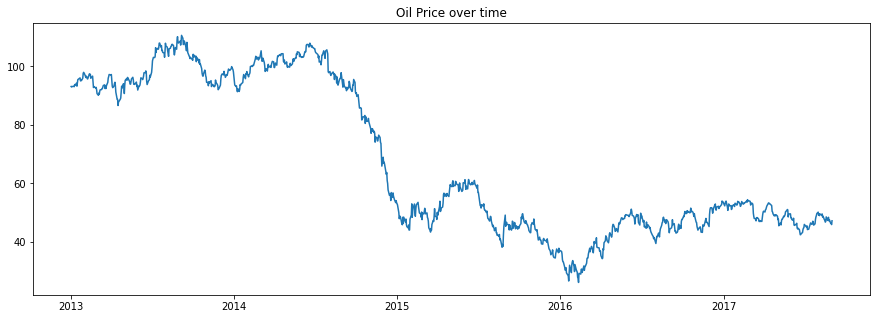

In [ ]:
fig,ax = plt.subplots(figsize=(15,5))
plt.plot(oil_data['interpolated_price'])
plt.title('Oil Price over time')

plt.show()

Now let's calculate the correlation between oil price and total sales.
Let's begin by a scatterplot

In [ ]:
daily_total_sales = total_sales.copy()

In [ ]:
daily_total_sales.head()

date
2013-01-01      2511.618999
2013-01-02    496092.417944
2013-01-03    361461.231124
2013-01-04    354459.677093
2013-01-05    477350.121229
Name: sales, dtype: float64

In [ ]:
daily_total_sales = daily_total_sales.resample('1D').sum()
daily_total_sales

date
2013-01-01      2511.618999
2013-01-02    496092.417944
2013-01-03    361461.231124
2013-01-04    354459.677093
2013-01-05    477350.121229
                  ...      
2017-08-11    826373.722022
2017-08-12    792630.535079
2017-08-13    865639.677471
2017-08-14    760922.406081
2017-08-15    762661.935939
Freq: D, Name: sales, Length: 1688, dtype: float64

In [ ]:
oil_data.interpolated_price.loc['2013-01-01':'2017-08-15']

date
2013-01-01          NaN
2013-01-02    93.140000
2013-01-03    92.970000
2013-01-04    93.120000
2013-01-05    93.146667
                ...    
2017-08-11    48.810000
2017-08-12    48.403333
2017-08-13    47.996667
2017-08-14    47.590000
2017-08-15    47.570000
Freq: D, Name: interpolated_price, Length: 1688, dtype: float64

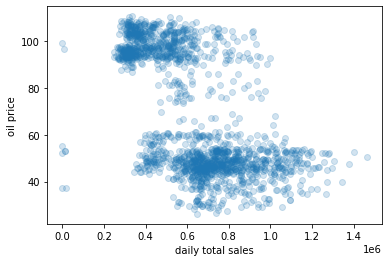

In [ ]:
plt.scatter(daily_total_sales,oil_data.interpolated_price.loc['2013-01-01':'2017-08-15'],alpha=0.2)
plt.ylabel('oil price')
plt.xlabel('daily total sales')
plt.show()

Cosidering the scatterplot there seems to be no obvious linear correlation between both of them. the most I could say is that higher the oil price, lower the sales. However let's consider another angle. The oil price changes vs total sales changes. We already have oil price change and percentage change. Let's prepare the daily_total_sales.

In [ ]:
daily_total_sales = pd.DataFrame(daily_total_sales)
daily_total_sales['sales_chg'] = daily_total_sales['sales']-daily_total_sales['sales'].shift(1)
daily_total_sales['sales_pct_chg'] = daily_total_sales['sales_chg']/daily_total_sales['sales'].shift(-1)

daily_total_sales.head()

sales      sales_chg  sales_pct_chg
date                                                   
2013-01-01    2511.618999            NaN            NaN
2013-01-02  496092.417944  493580.798945       1.365515
2013-01-03  361461.231124 -134631.186820      -0.379821
2013-01-04  354459.677093   -7001.554031      -0.014668
2013-01-05  477350.121229  122890.444136       0.236466

Let's find correlation betwenn the amount change and percentage change of both oil and sales.

In [ ]:
print('Spearman Rank Correlation = {}'.format(
    process_train.sales.corr(process_train.onpromotion,method='spearman')))

Spearman Rank Correlation = 0.5380218163559225


In [ ]:
print('Pearson Correlation between oil price change and total sales change = {}'.format(
oil_data.price_chg.corr(daily_total_sales.sales_chg,method='pearson')))
print('Spearman Rank Correlation between oil price change and total sales change = {}'.format(
oil_data.price_chg.corr(daily_total_sales.sales_chg,method='spearman')))

print('============================================================================')

print('Pearson Correlation between % oil price change and % total sales change = {}'.format(
oil_data.pct_chg.corr(daily_total_sales.sales_pct_chg,method='pearson')))
print('Spearman Rank Correlation between oil price change and total sales change = {}'.format(
oil_data.pct_chg.corr(daily_total_sales.sales_pct_chg,method='spearman')))

Pearson Correlation between oil price change and total sales change = 0.0005043962495408222
Spearman Rank Correlation between oil price change and total sales change = -0.012220920016204567
Pearson Correlation between % oil price change and % total sales change = nan
Spearman Rank Correlation between oil price change and total sales change = -0.009634310217587974


### What about Oil Lag??
Let's check another angle. The correlation between the oil price lag and the sales just in case that the effect from change in oil price talk times to be fully accounted into people shopping pattern.

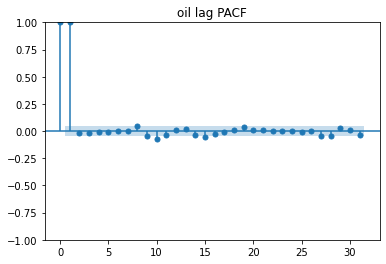

In [ ]:
import  statsmodels.graphics.tsaplots # for partial autocorrelation

ax = statsmodels.graphics.tsaplots.plot_pacf(oil_data.interpolated_price.dropna(), 
                                                 lags=31,
                                                 title = 'oil lag PACF')

Oil price lag 10,15,26,27 is good to used. Let's see if there are any corelation to the sales.

In [ ]:
oil_lag = [10,15,26,27]
for lag in oil_lag:
    oil_data['price_lag_{}'.format(lag)] = oil_data.interpolated_price.shift(lag)

In [ ]:
oil_for_lag_coor = oil_data.dropna()
oil_for_lag_coor.head()

interpolated_price  price_chg   pct_chg  price_lag_10  \
date                                                                
2013-01-29           97.620000   1.670000  0.017044         95.73   
2013-01-30           97.980000   0.360000  0.003687         95.85   
2013-01-31           97.650000  -0.330000 -0.003386         95.97   
2013-02-01           97.460000  -0.190000 -0.001958         96.09   
2013-02-02           97.043333  -0.416667 -0.004312         95.06   

            price_lag_15  price_lag_26  price_lag_27  
date                                                  
2013-01-29         94.27     92.970000     93.140000  
2013-01-30         93.26     93.120000     92.970000  
2013-01-31         94.28     93.146667     93.120000  
2013-02-01         95.49     93.173333     93.146667  
2013-02-02         95.61     93.200000     93.173333

In [ ]:
oil_for_lag_coor = oil_for_lag_coor.merge(daily_total_sales,how='inner',left_index=True,right_index=True)

In [ ]:
oil_for_lag_coor = oil_for_lag_coor[['price_lag_10','price_lag_15','price_lag_26','price_lag_27','sales']]
oil_for_lag_coor.head()

price_lag_10  price_lag_15  price_lag_26  price_lag_27  \
date                                                                 
2013-01-29         95.73         94.27     92.970000     93.140000   
2013-01-30         95.85         93.26     93.120000     92.970000   
2013-01-31         95.97         94.28     93.146667     93.120000   
2013-02-01         96.09         95.49     93.173333     93.146667   
2013-02-02         95.06         95.61     93.200000     93.173333   

                    sales  
date                       
2013-01-29  264488.818076  
2013-01-30  281061.127052  
2013-01-31  271254.217996  
2013-02-01  369402.055266  
2013-02-02  518887.462705

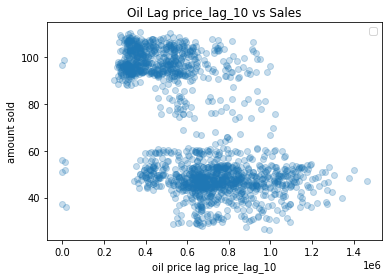

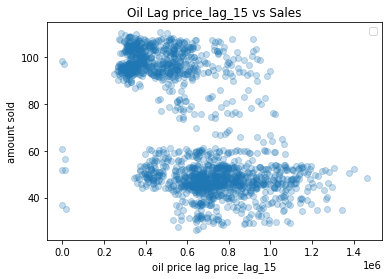

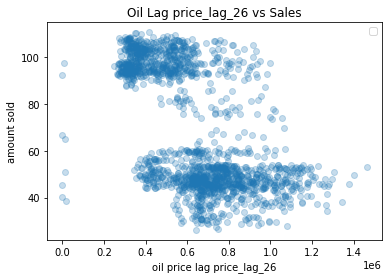

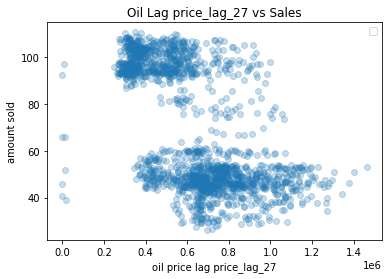

In [ ]:
fig, ax = plt.subplots()
lag_col =  ['price_lag_10','price_lag_15','price_lag_26','price_lag_27']

for lag in lag_col:
    plt.scatter(oil_for_lag_coor['sales'],oil_for_lag_coor[lag],alpha=0.25)
    plt.title('Oil Lag {} vs Sales'.format(lag))
    plt.xlabel('oil price lag {}'.format(lag))
    plt.ylabel('amount sold')
    plt.legend()
    plt.show()

Noting Obvoius again. Higher the lag price, lower the sales. This just mightbe the result from the fact that the oil price had been dropping while the sales is getting better. A correlation, maybe, a causation, I don't know. 

PS. If someone could shed some light on this topic, please elaborate on the discussion panel please.

As of now, I woudn't use the oil price as a feature.

In [ ]:
del [oil_lag,oil_data,oil_for_lag_coor,lag_col]

gc.collect()

117297

### The Transaction record

In [ ]:
transactions = transaction_data.copy()
transactions = transactions.set_index('date')

del transaction_data

I really feel like this must be a very powerful feature. The transaction amount must be highly corelated with the sales. Let's process it by
1. Make a dic cotain store_nbr as a key and transaction as elements
2. Interpolate the missing date in the dic
3. scatterplot the transaction with total sales record
4. decide if assumption is good to be used in the model 

In [ ]:
transactions.index = pd.to_datetime(transactions.index)

In [ ]:
transactions.head()

store_nbr  transactions
date                               
2013-01-01         25           770
2013-01-02          1          2111
2013-01-02          2          2358
2013-01-02          3          3487
2013-01-02          4          1922

In [ ]:
def transaction_sales_dic(transaction_df,sale_dic):
    transaction_dic = {}
    sale_dict = sale_dic.copy()

    for i in transaction_df['store_nbr'].unique():
        store_transacion = transaction_df.loc[transaction_df['store_nbr'] == i]
        transaction_dic[i] = store_transacion['transactions']
        
    for i in sale_dict.keys():
        sale_dict[i] = sale_dict[i].groupby(['date','store_nbr']).sales.sum()
        sale_dict[i] = sale_dict[i].reset_index()
        sale_dict[i] = sale_dict[i].drop('store_nbr', axis=1)
        sale_dict[i] = sale_dict[i].groupby('date').sales.sum()
            
    return transaction_dic, sale_dict
        
def  series_merge_inner_index(dic1, dic2):
    merged_dic = {}
    for key in dic1.keys():
        merged_dic[key] = dic1[key].to_frame().merge(dic2[key].to_frame(), how='inner',
                                                    left_index=True, right_index=True)
    return merged_dic

In [ ]:
transaction_dic, sale_dic = transaction_sales_dic(transactions,daily_sale_dict)
merged_sales_transaction = series_merge_inner_index(transaction_dic, sale_dic)
merged_sales_transaction[1] #just for checking the outcome

transactions         sales
date                                  
2013-01-02          2111   7417.148000
2013-01-03          1833   5873.244001
2013-01-04          1863   5919.879001
2013-01-05          1509   6318.785010
2013-01-06           520   2199.087000
...                  ...           ...
2017-08-11           570   5403.742021
2017-08-12          1004   7543.623000
2017-08-13           416   3902.782000
2017-08-14          1733  10433.314000
2017-08-15          1693   9823.551018

[1676 rows x 2 columns]

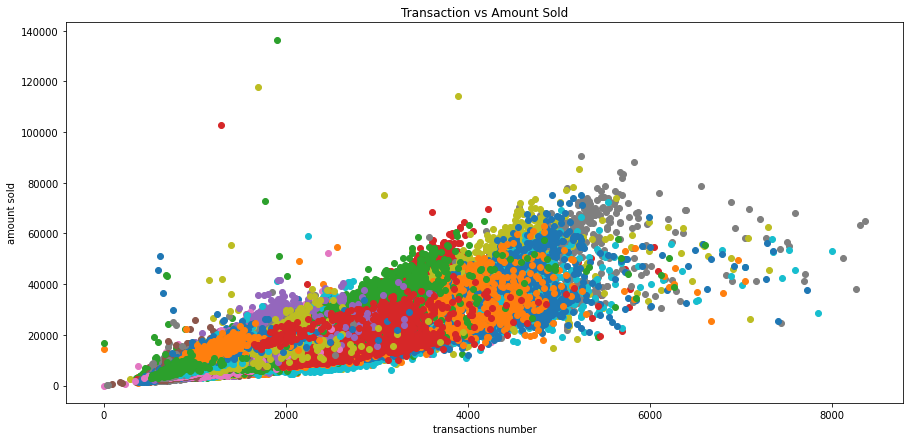

In [ ]:
fig, ax = plt.subplots(figsize=(15,7))
for key in merged_sales_transaction.keys():
    plt.scatter(merged_sales_transaction[key].transactions,
                merged_sales_transaction[key].sales)

plt.title('Transaction vs Amount Sold')
plt.xlabel('transactions number')
plt.ylabel('amount sold')
plt.show()

This is very obvious that transaction number and amount sold are highly corelated. This feature will be used in the model. Considering the nature of test dataset that didn't provide the amount of transaction on those days (otherwise there will be a data leakage), Transaction must be used as a lag feature. In fact, it need to be a 16 or more lag since the test horizon is 15 days from the last day of the training dataset.

Let's see transaction lag. Beginning with the transaction lag partial correlation for picking the good lags to use.

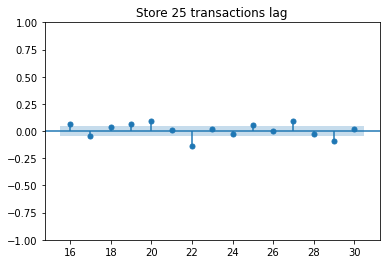

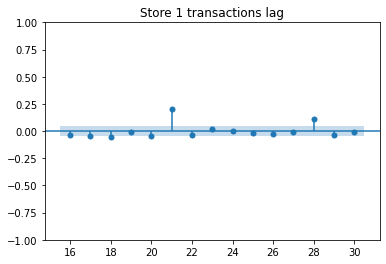

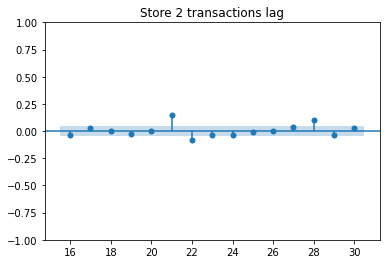

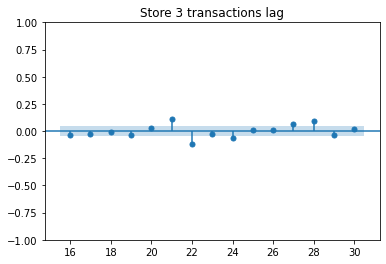

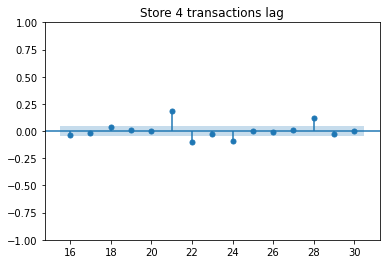

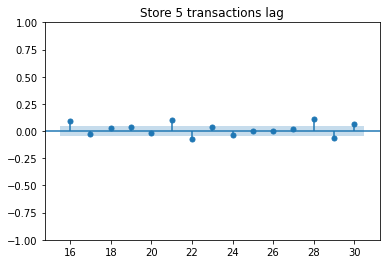

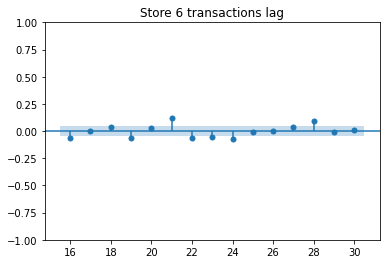

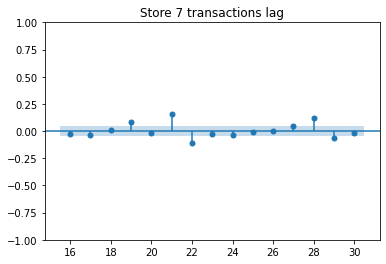

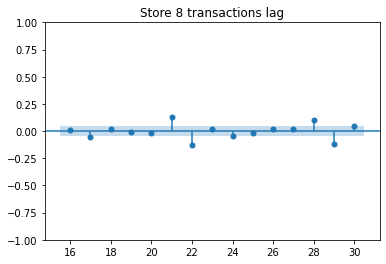

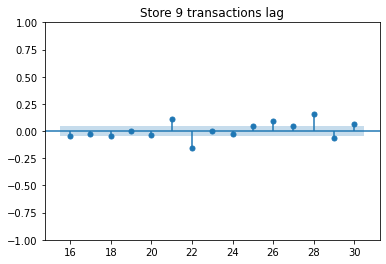

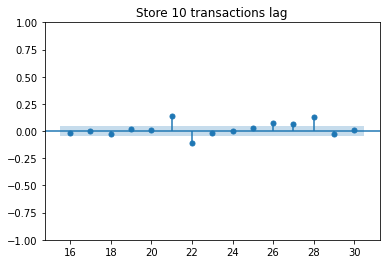

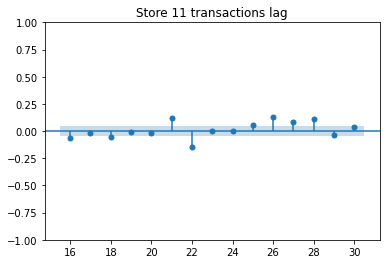

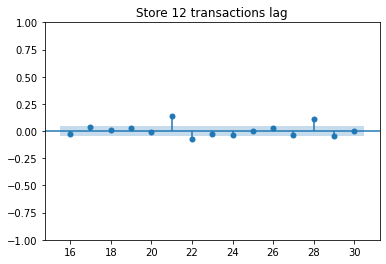

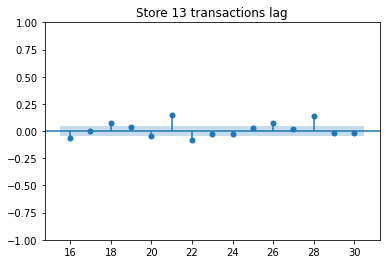

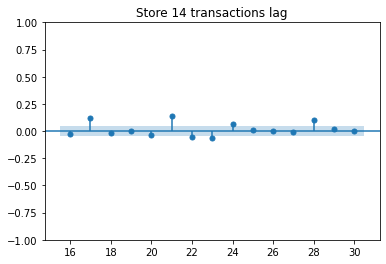

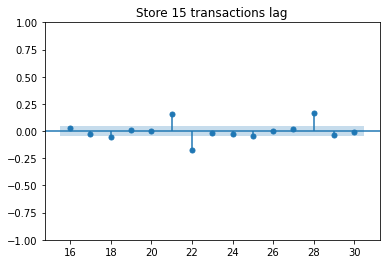

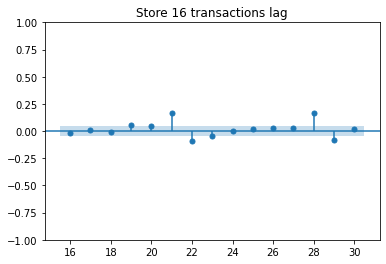

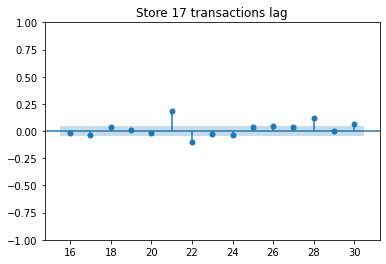

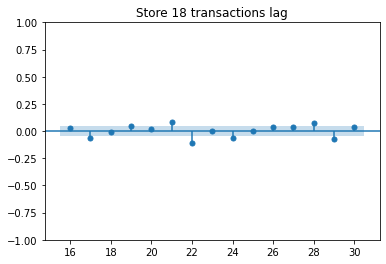

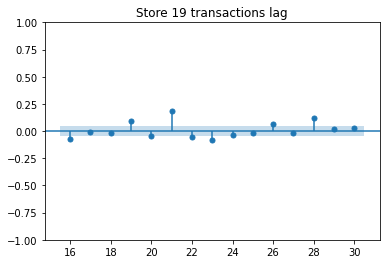

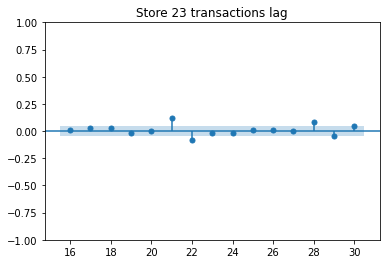

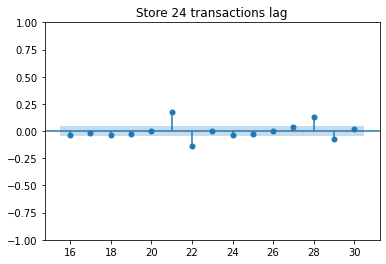

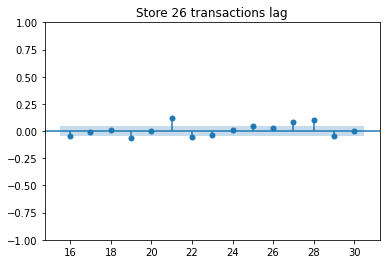

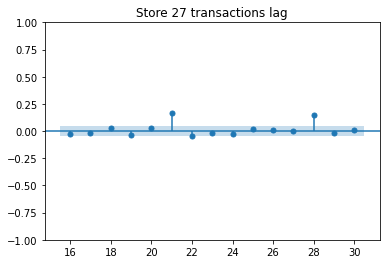

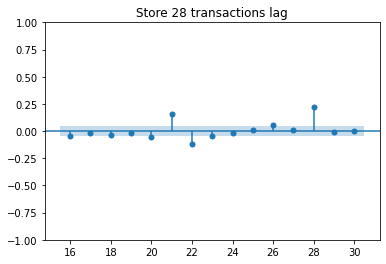

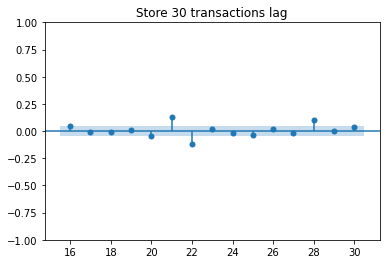

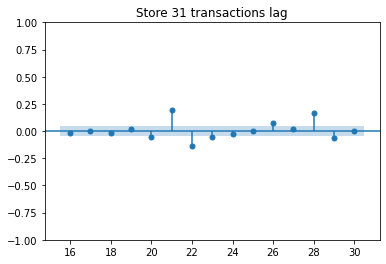

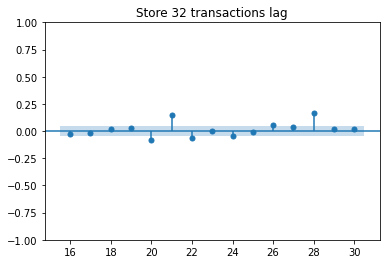

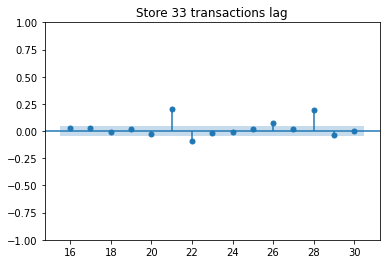

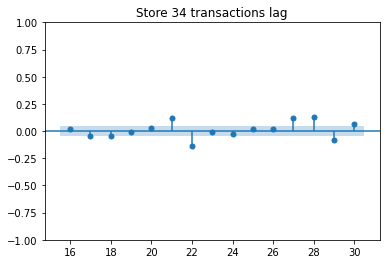

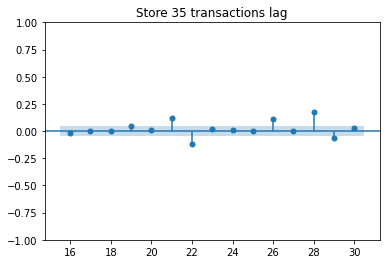

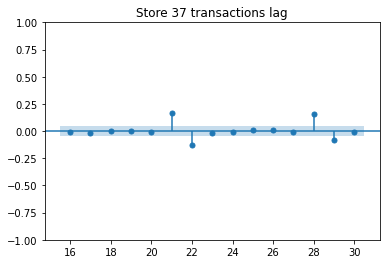

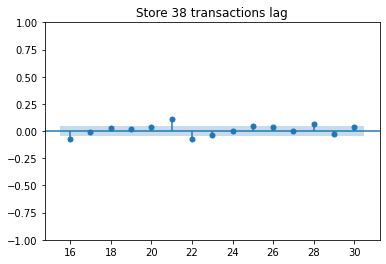

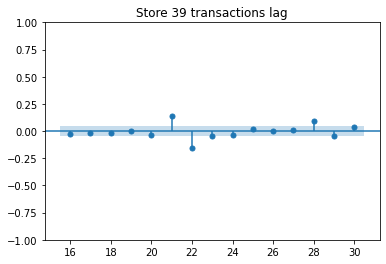

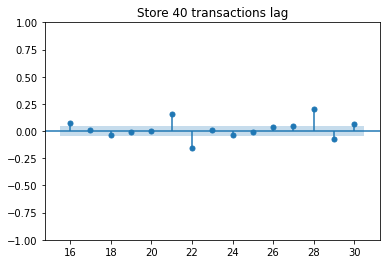

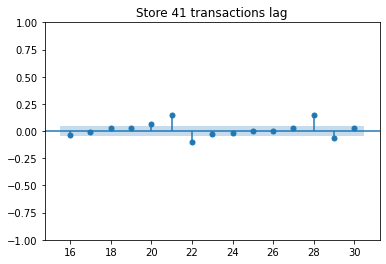

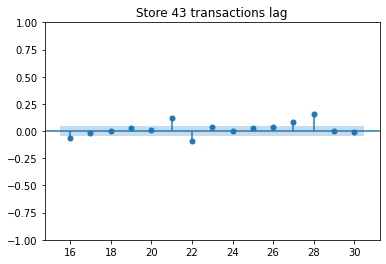

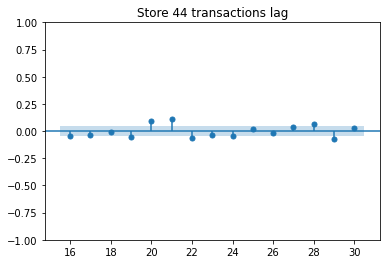

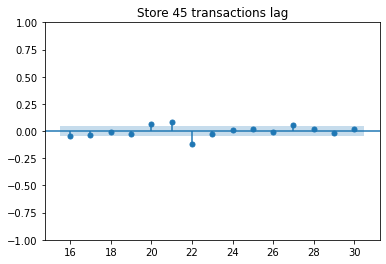

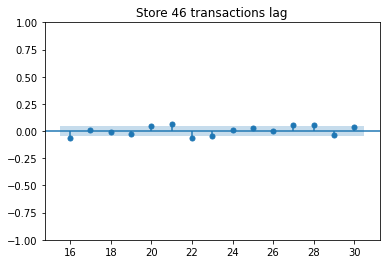

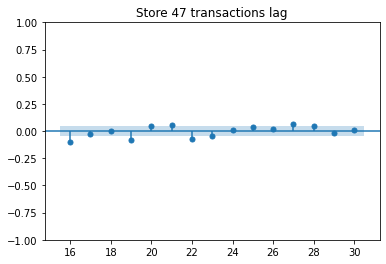

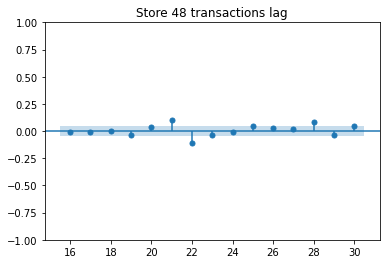

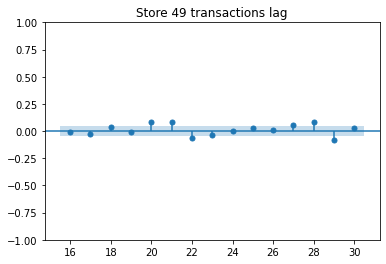

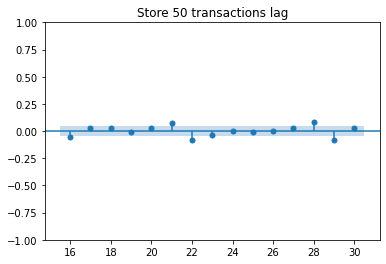

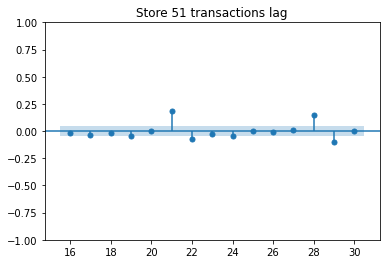

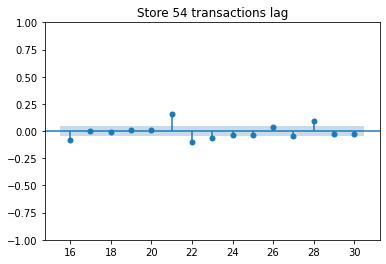

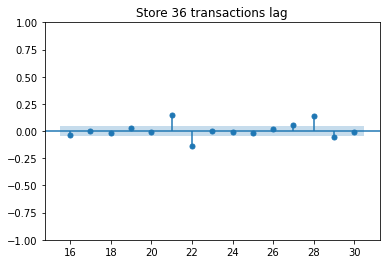

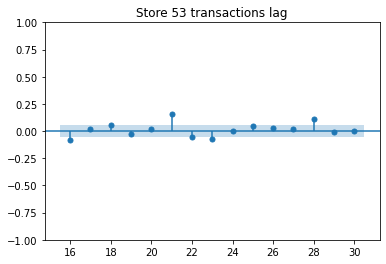

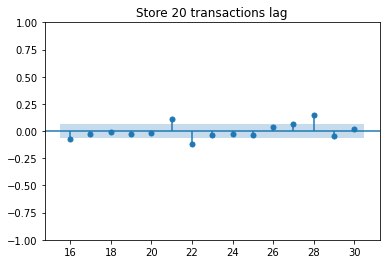

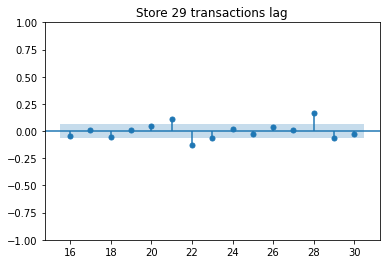

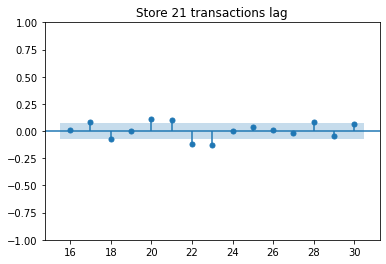

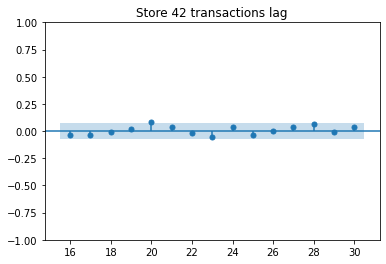

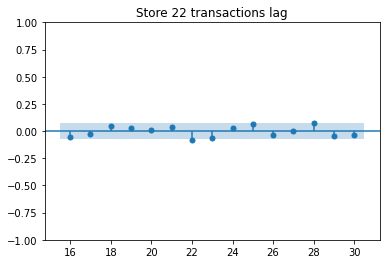

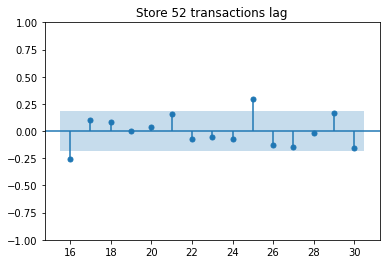

In [ ]:
import  statsmodels.graphics.tsaplots # for partial autocorrelation

for store_nbr in merged_sales_transaction.keys():
    ax = statsmodels.graphics.tsaplots.plot_pacf(merged_sales_transaction[store_nbr].transactions, 
                                                 lags=range(16,31),
                                                 title = 'Store {} transactions lag'.format(store_nbr))

Interestingly, the transaction lag of 21,22,28 seems to be good enough to be used in place of almost all the stores. We will use them as feature.

### From what I plan to explore:

1. Total sales
2. Daily sales by each stores
3. Sales by product family, by time
4. Store Location/Cluster Effect on sales
5. Onpromotion effect on sales
6. Cycle and Seasonal Effect on total sales
7. Map the holiday to the sales record
8. Calculate the correlation in change in oil price to change in total sales
9. Explore the transaction data




### This is what I have
1. The overall trend is up for total sales 
2. the top 5
   * GROCERY I - 31.99%
   * BEVERAGES - 20.21%
   * PRODUCE - 11.43%
   * CLEANING - 9.08%
   * DAIRY - 6% 
   
   accounted for more than 75% of total sales
   * Frozen Food / School and Office Supply, though not a major share, has a highly cyclic selling pattern
  
3. Some store have a lot of missing dates. I guess it's not operate or not yet open on those days
   * Closing days besides, all the other store have high corelation in daily sales change.
4. There are some interesting paterns within the sales need further explorations such as:
    * The earthquale effect
    * The New Year
5. Store characteristic are categorized by cluster, format. Let's see their significance later when we build and train the model.
    * Type and Cluster seem to have some effect on sales.
    * The sores located most in Pichincha and Guayas
    
6. There are strong corelation between onpromotion and sales of the product on promotion
7. On average, sales are higher around the end of the week  on weekly basis an higher around Q4 on yearly basis
8. The dummy DF for holiday is ready to be merge to the main sales DF
9. Oil price seem to have no corralation to the sales amount.
10. Transaction number is highly corelated to total sales.
    * Will be used as lag feature (lag 21,22,28)

# 4. Model research: Which model should I use here.

Since this is the first attempt and I already have a benchmark score from the kaggele time series course of **0.51090**, I think I will begin with simple linear regression. Later, I plan to refine or replace the model or methodology used for building the model for better outcome.

# 5. Data processing and Feature engineering

With the exploration so far. I plan to train the model with these features
* Daily Sales lag (Will check again for different lag correlations)
* Total daily sales lag Across the country
* The amount of the promotion for that product family
* Store Area (to be crossed with the locale name of holiday)
* Features from Holiday
    * type
    * locale name
    * day of week
    * is_worlday
    * Earthquake
    * Football
    * New Year
    * shopping events (such as Black Friday)
* Daily Transaction Lag for each shop

We are already have the holiday_df ready to be merge. Let's begin making inputs dataframe. 


### Lag Feature
First thing first, let's explore the sales lag correlation to the sales itself.

Also the test dataset come in different product family and different store, I don't want to construct the lag for each product family and each store and the majority of the product sold are consist of only 5 family. Therefore,I'm gonna use only the lag from store total sales.


In [ ]:
import  statsmodels.graphics.tsaplots # for partial autocorrelation


daily_store_sale_dict = {}
for i in daily_sale_dict.keys():
    daily_store_sale_dict[i] = daily_sale_dict[i].groupby(['date','store_nbr']).sales.sum().to_frame()    

In [ ]:
del daily_sale_dict

In [ ]:
daily_store_sale_dict[1].head() #just checking for store 1 dic

sales
date       store_nbr             
2013-01-01 1             0.000000
2013-01-02 1          7417.148000
2013-01-03 1          5873.244001
2013-01-04 1          5919.879001
2013-01-05 1          6318.785010

In [ ]:
for i in daily_store_sale_dict.keys():
    daily_store_sale_dict[i] = daily_store_sale_dict[i].droplevel(1) 
    #remove store_nbt from index leaving only date

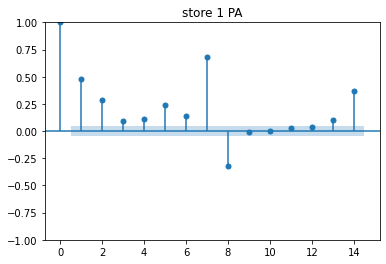

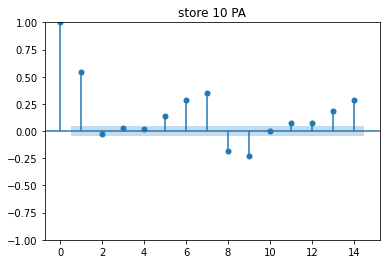

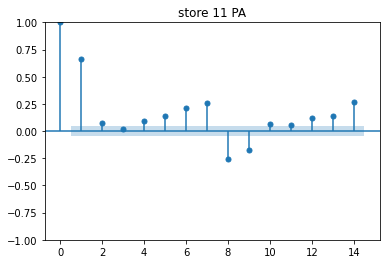

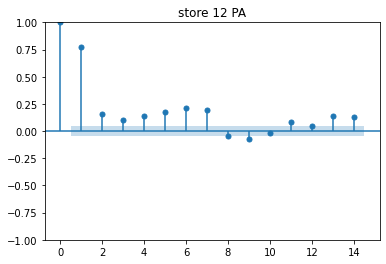

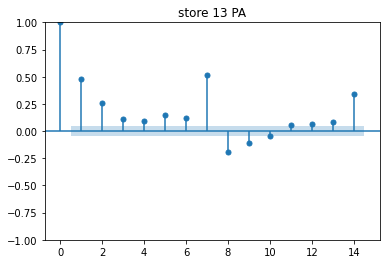

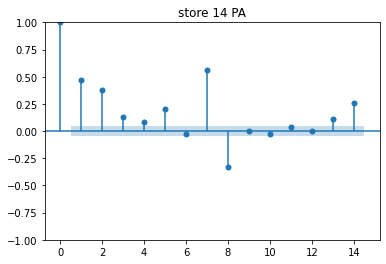

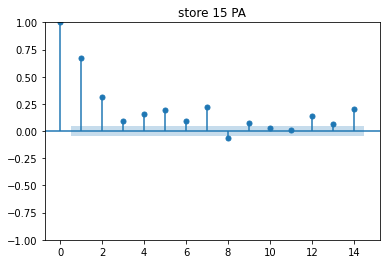

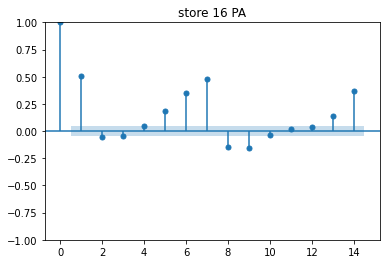

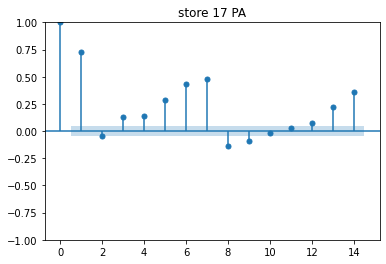

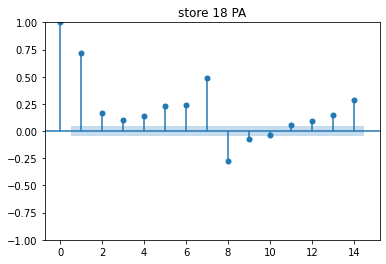

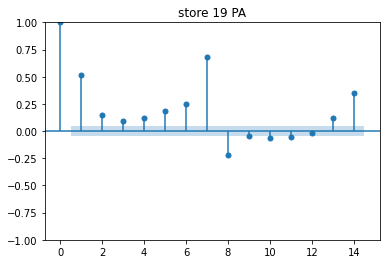

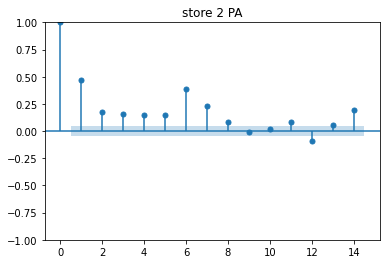

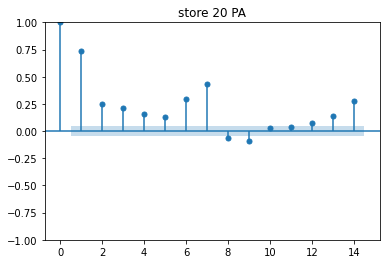

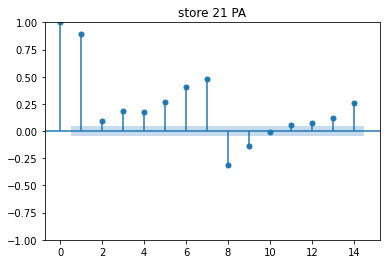

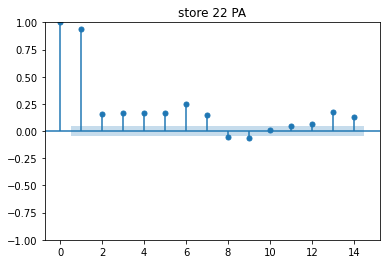

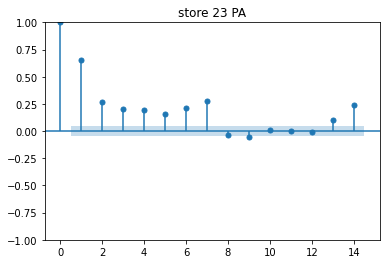

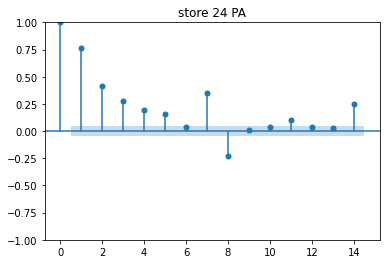

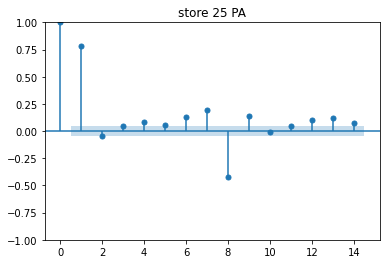

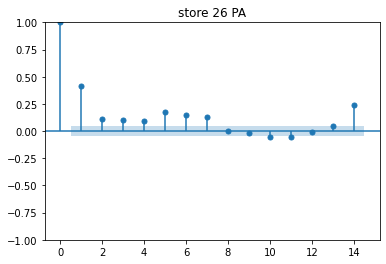

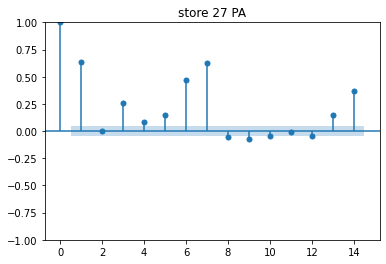

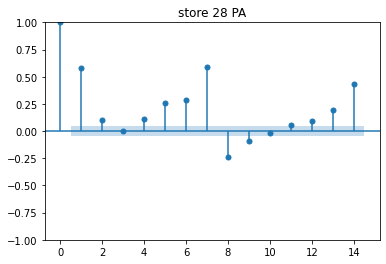

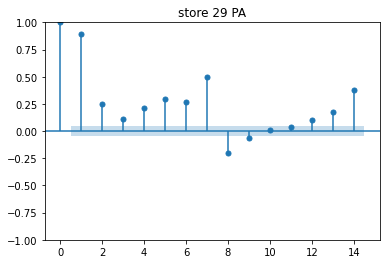

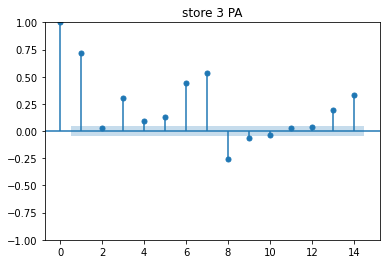

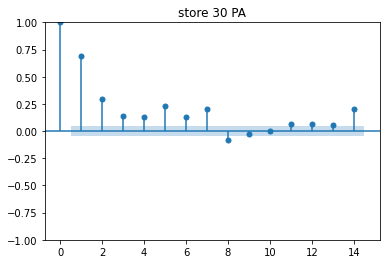

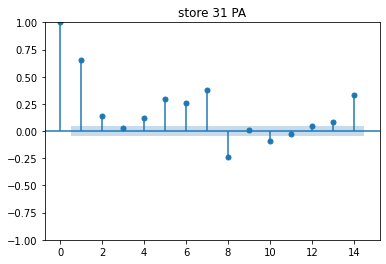

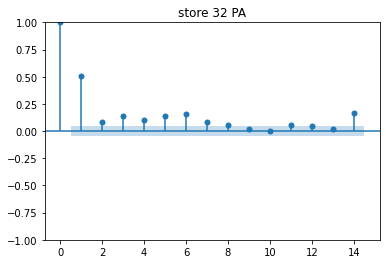

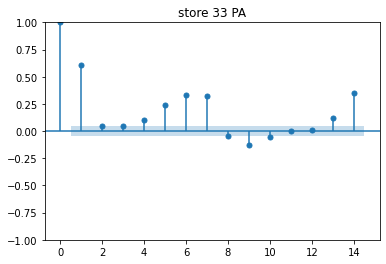

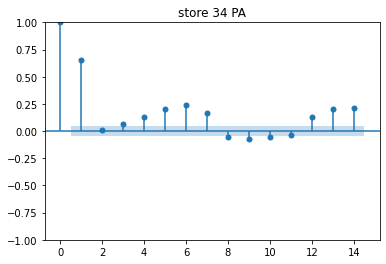

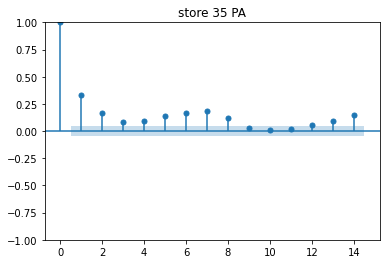

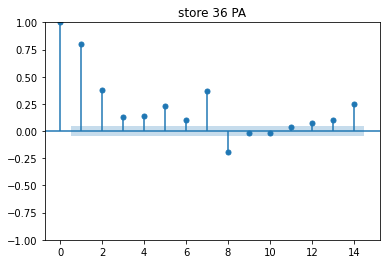

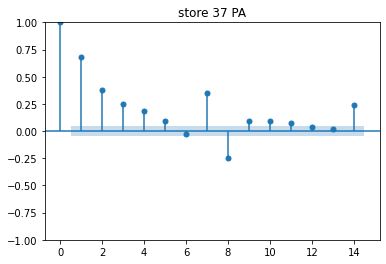

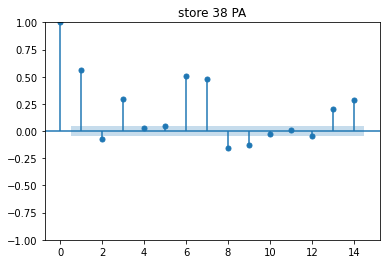

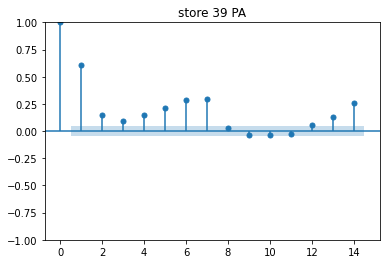

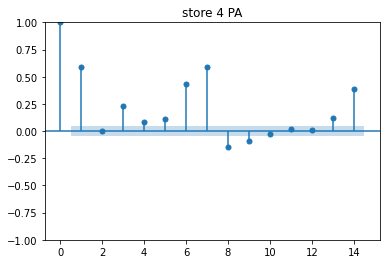

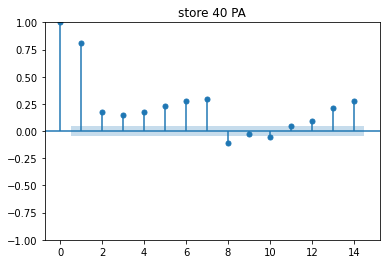

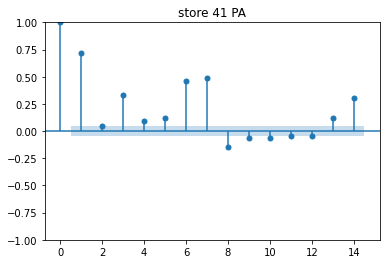

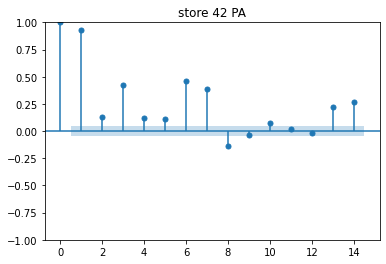

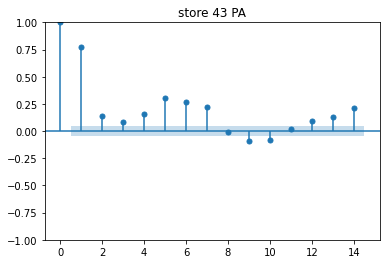

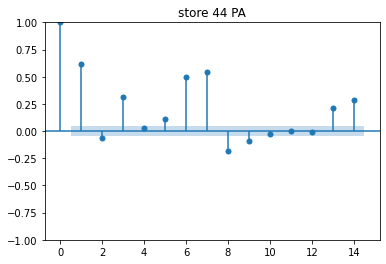

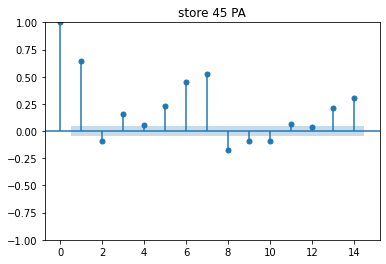

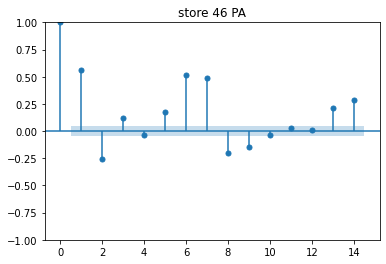

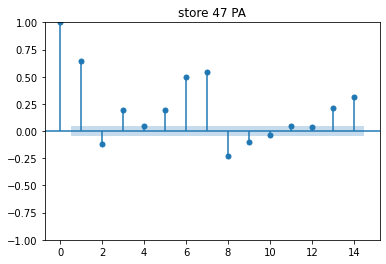

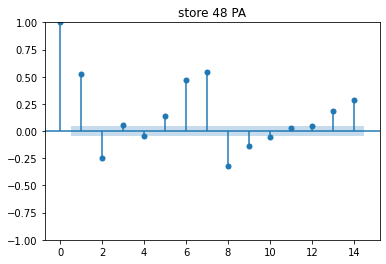

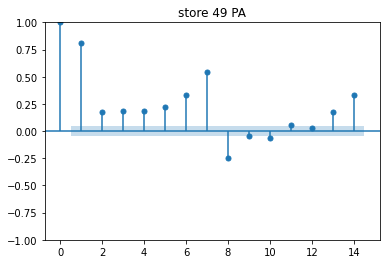

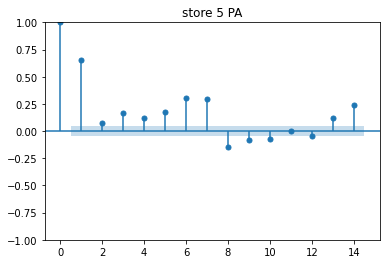

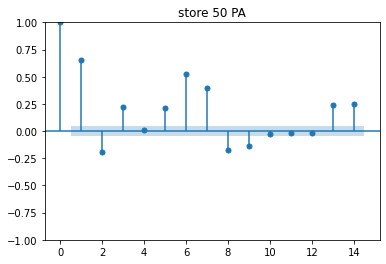

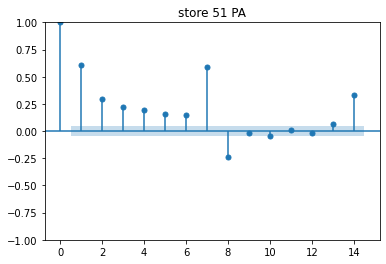

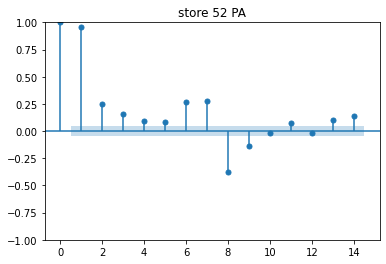

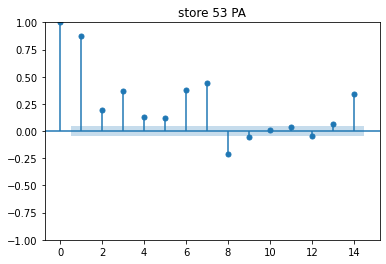

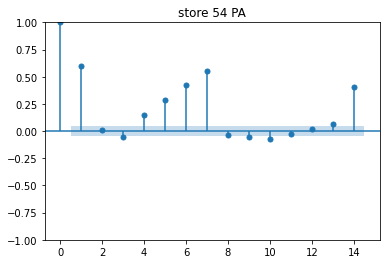

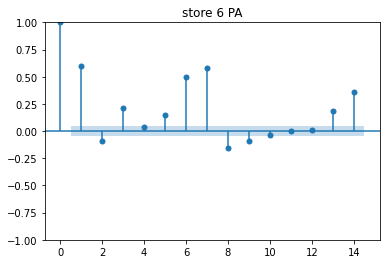

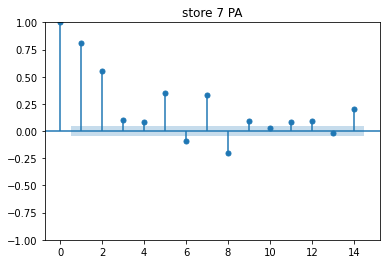

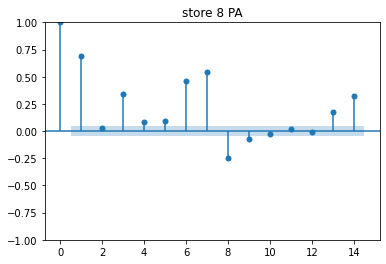

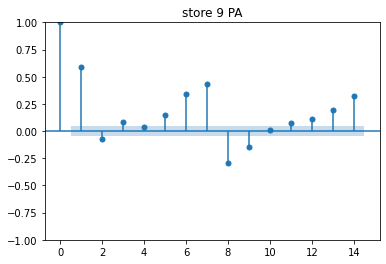

In [ ]:
for i in daily_store_sale_dict.keys():

    ax = statsmodels.graphics.tsaplots.plot_pacf(daily_store_sale_dict[i],lags=14, 
                                                 title = 'store {} PA'.format(i))

I thin I will keep the 1 2 3 4 5 6 7 8 13 14 Lags.

The lag is prepared. Let' start constructing the input df along the way.

Let's combine the process_train and test for the ease of formatting

In [ ]:
process_train

store_nbr                      family     sales  onpromotion
date                                                                    
2013-01-01          1                  AUTOMOTIVE     0.000            0
2013-01-01          1                   BABY CARE     0.000            0
2013-01-01          1                      BEAUTY     0.000            0
2013-01-01          1                   BEVERAGES     0.000            0
2013-01-01          1                       BOOKS     0.000            0
...               ...                         ...       ...          ...
2017-08-15          9                     POULTRY   438.133            0
2017-08-15          9              PREPARED FOODS   154.553            1
2017-08-15          9                     PRODUCE  2419.729          148
2017-08-15          9  SCHOOL AND OFFICE SUPPLIES   121.000            8
2017-08-15          9                     SEAFOOD    16.000            0

[3000888 rows x 4 columns]

In [ ]:
test_data.head()

id        date  store_nbr      family  onpromotion
0  3000888  2017-08-16          1  AUTOMOTIVE            0
1  3000889  2017-08-16          1   BABY CARE            0
2  3000890  2017-08-16          1      BEAUTY            2
3  3000891  2017-08-16          1   BEVERAGES           20
4  3000892  2017-08-16          1       BOOKS            0

In [ ]:
test_data['sales'] = 0
test_data = test_data[['id','date','store_nbr','family','sales','onpromotion']]

test_data

id        date  store_nbr                      family  sales  \
0      3000888  2017-08-16          1                  AUTOMOTIVE      0   
1      3000889  2017-08-16          1                   BABY CARE      0   
2      3000890  2017-08-16          1                      BEAUTY      0   
3      3000891  2017-08-16          1                   BEVERAGES      0   
4      3000892  2017-08-16          1                       BOOKS      0   
...        ...         ...        ...                         ...    ...   
28507  3029395  2017-08-31          9                     POULTRY      0   
28508  3029396  2017-08-31          9              PREPARED FOODS      0   
28509  3029397  2017-08-31          9                     PRODUCE      0   
28510  3029398  2017-08-31          9  SCHOOL AND OFFICE SUPPLIES      0   
28511  3029399  2017-08-31          9                     SEAFOOD      0   

       onpromotion  
0                0  
1                0  
2                2  
3               20  
4                0  
...            ...  
28507            1  
28508            0  
28509            1  
28510            9  
28511            0  

[28512 rows x 6 columns]

In [ ]:
process_train['id'] = process_train.reset_index().index

In [ ]:
process_train = process_train.reset_index()
process_train = process_train[['id','date','store_nbr','family','sales','onpromotion']]
process_train

id       date  store_nbr                      family     sales  \
0              0 2013-01-01          1                  AUTOMOTIVE     0.000   
1              1 2013-01-01          1                   BABY CARE     0.000   
2              2 2013-01-01          1                      BEAUTY     0.000   
3              3 2013-01-01          1                   BEVERAGES     0.000   
4              4 2013-01-01          1                       BOOKS     0.000   
...          ...        ...        ...                         ...       ...   
3000883  3000883 2017-08-15          9                     POULTRY   438.133   
3000884  3000884 2017-08-15          9              PREPARED FOODS   154.553   
3000885  3000885 2017-08-15          9                     PRODUCE  2419.729   
3000886  3000886 2017-08-15          9  SCHOOL AND OFFICE SUPPLIES   121.000   
3000887  3000887 2017-08-15          9                     SEAFOOD    16.000   

         onpromotion  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  
...              ...  
3000883            0  
3000884            1  
3000885          148  
3000886            8  
3000887            0  

[3000888 rows x 6 columns]

In [ ]:
merged_train = pd.concat([process_train,test_data])
merged_train = merged_train.set_index(['date','store_nbr','family'])
merged_train

id  sales  onpromotion
date       store_nbr family                                                 
2013-01-01 1         AUTOMOTIVE                        0    0.0            0
                     BABY CARE                         1    0.0            0
                     BEAUTY                            2    0.0            0
                     BEVERAGES                         3    0.0            0
                     BOOKS                             4    0.0            0
...                                                  ...    ...          ...
2017-08-31 9         POULTRY                     3029395    0.0            1
                     PREPARED FOODS              3029396    0.0            0
                     PRODUCE                     3029397    0.0            1
                     SCHOOL AND OFFICE SUPPLIES  3029398    0.0            9
                     SEAFOOD                     3029399    0.0            0

[3029400 rows x 3 columns]

In [ ]:
merged_train

id  sales  onpromotion
date       store_nbr family                                                 
2013-01-01 1         AUTOMOTIVE                        0    0.0            0
                     BABY CARE                         1    0.0            0
                     BEAUTY                            2    0.0            0
                     BEVERAGES                         3    0.0            0
                     BOOKS                             4    0.0            0
...                                                  ...    ...          ...
2017-08-31 9         POULTRY                     3029395    0.0            1
                     PREPARED FOODS              3029396    0.0            0
                     PRODUCE                     3029397    0.0            1
                     SCHOOL AND OFFICE SUPPLIES  3029398    0.0            9
                     SEAFOOD                     3029399    0.0            0

[3029400 rows x 3 columns]

In [ ]:
del test_data
gc.collect()

42

let's add the store location as another index.

In [ ]:
store_location = store_data.drop(['state','type','cluster'],axis=1) # the city column is the same scale as holiday location.
store_location = store_location.set_index('store_nbr')
store_location = pd.get_dummies(store_location,prefix='store_loc_')
store_location

store_loc__Ambato  store_loc__Babahoyo  store_loc__Cayambe  \
store_nbr                                                               
1                          0                    0                   0   
2                          0                    0                   0   
3                          0                    0                   0   
4                          0                    0                   0   
5                          0                    0                   0   
6                          0                    0                   0   
7                          0                    0                   0   
8                          0                    0                   0   
9                          0                    0                   0   
10                         0                    0                   0   
11                         0                    0                   1   
12                         0                    0                   0   
13                         0                    0                   0   
14                         0                    0                   0   
15                         0                    0                   0   
16                         0                    0                   0   
17                         0                    0                   0   
18                         0                    0                   0   
19                         0                    0                   0   
20                         0                    0                   0   
21                         0                    0                   0   
22                         0                    0                   0   
23                         1                    0                   0   
24                         0                    0                   0   
25                         0                    0                   0   
26                         0                    0                   0   
27                         0                    0                   0   
28                         0                    0                   0   
29                         0                    0                   0   
30                         0                    0                   0   
31                         0                    1                   0   
32                         0                    0                   0   
33                         0                    0                   0   
34                         0                    0                   0   
35                         0                    0                   0   
36                         0                    0                   0   
37                         0                    0                   0   
38                         0                    0                   0   
39                         0                    0                   0   
40                         0                    0                   0   
41                         0                    0                   0   
42                         0                    0                   0   
43                         0                    0                   0   
44                         0                    0                   0   
45                         0                    0                   0   
46                         0                    0                   0   
47                         0                    0                   0   
48                         0                    0                   0   
49                         0                    0                   0   
50                         1                    0                   0   
51                         0                    0                   0   
52                         0                    0                   0   
53                         0                    0                   0

merge the store location into inputs DF 

In [ ]:
inputs = merged_train.reset_index().merge(store_location,how='outer',left_on='store_nbr',right_on=store_location.index)

In [ ]:
inputs

date  store_nbr                      family       id  sales  \
0       2013-01-01          1                  AUTOMOTIVE        0    0.0   
1       2013-01-01          1                   BABY CARE        1    0.0   
2       2013-01-01          1                      BEAUTY        2    0.0   
3       2013-01-01          1                   BEVERAGES        3    0.0   
4       2013-01-01          1                       BOOKS        4    0.0   
...            ...        ...                         ...      ...    ...   
3029395 2017-08-31          9                     POULTRY  3029395    0.0   
3029396 2017-08-31          9              PREPARED FOODS  3029396    0.0   
3029397 2017-08-31          9                     PRODUCE  3029397    0.0   
3029398 2017-08-31          9  SCHOOL AND OFFICE SUPPLIES  3029398    0.0   
3029399 2017-08-31          9                     SEAFOOD  3029399    0.0   

         onpromotion  store_loc__Ambato  store_loc__Babahoyo  \
0                  0                  0                    0   
1                  0                  0                    0   
2                  0                  0                    0   
3                  0                  0                    0   
4                  0                  0                    0   
...              ...                ...                  ...   
3029395            1                  0                    0   
3029396            0                  0                    0   
3029397            1                  0                    0   
3029398            9                  0                    0   
3029399            0                  0                    0   

         store_loc__Cayambe  store_loc__Cuenca  ...  store_loc__Loja  \
0                         0                  0  ...                0   
1                         0                  0  ...                0   
2                         0                  0  ...                0   
3                         0                  0  ...                0   
4                         0                  0  ...                0   
...                     ...                ...  ...              ...   
3029395                   0                  0  ...                0   
3029396                   0                  0  ...                0   
3029397                   0                  0  ...                0   
3029398                   0                  0  ...                0   
3029399                   0                  0  ...                0   

         store_loc__Machala  store_loc__Manta  store_loc__Playas  \
0                         0                 0                  0   
1                         0                 0                  0   
2                         0                 0                  0   
3                         0                 0                  0   
4                         0                 0                  0   
...                     ...               ...                ...   
3029395                   0                 0                  0   
3029396                   0                 0                  0   
3029397                   0                 0                  0   
3029398                   0                 0                  0   
3029399                   0                 0                  0   

         store_loc__Puyo  store_loc__Quevedo  store_loc__Quito  \
0                      0                   0                 1   
1                      0                   0                 1   
2                      0                   0                 1   
3                      0                   0                 1   
4                      0                   0                 1   
...                  ...                 ...               ...   
3029395                0                   0                 1   
3029396                0                   0                 1   
3029397                0                   0

In [ ]:
del store_location
del merged_train
gc.collect()

21

Next, lag features: sales lag, total daily sales lag, transaction lag. I have prepared the store sales lag and tranasation lag, let's do the total country sales lag.

In [ ]:
total_sales

date
2013-01-01      2511.618999
2013-01-02    496092.417944
2013-01-03    361461.231124
2013-01-04    354459.677093
2013-01-05    477350.121229
                  ...      
2017-08-11    826373.722022
2017-08-12    792630.535079
2017-08-13    865639.677471
2017-08-14    760922.406081
2017-08-15    762661.935939
Name: sales, Length: 1684, dtype: float64

Need to project the index further to 2017-08-31.

In [ ]:
total_sales_to_scale = pd.DataFrame(index=pd.date_range(start='2013-01-01',end='2017-08-31'))
total_sales_to_scale = total_sales_to_scale.merge(total_sales,how='left',left_index=True,right_index=True)
total_sales_to_scale = total_sales_to_scale.rename(columns={'sales':'national_sales'})

In [ ]:
total_sales_to_scale

national_sales
2013-01-01     2511.618999
2013-01-02   496092.417944
2013-01-03   361461.231124
2013-01-04   354459.677093
2013-01-05   477350.121229
...                    ...
2017-08-27             NaN
2017-08-28             NaN
2017-08-29             NaN
2017-08-30             NaN
2017-08-31             NaN

[1704 rows x 1 columns]

In [ ]:
from sklearn.preprocessing import MinMaxScaler
mmScale = MinMaxScaler()
mmScale.fit(total_sales_to_scale['national_sales'].to_numpy().reshape(-1,1))

total_sales_to_scale['scaled_nat_sales'] = mmScale.transform(total_sales_to_scale['national_sales'].to_numpy().reshape(-1,1))


In [ ]:
total_sales_to_scale

national_sales  scaled_nat_sales
2013-01-01     2511.618999          0.000000
2013-01-02   496092.417944          0.337937
2013-01-03   361461.231124          0.245760
2013-01-04   354459.677093          0.240966
2013-01-05   477350.121229          0.325104
...                    ...               ...
2017-08-27             NaN               NaN
2017-08-28             NaN               NaN
2017-08-29             NaN               NaN
2017-08-30             NaN               NaN
2017-08-31             NaN               NaN

[1704 rows x 2 columns]

Next, we need to make some lags to the scaled_nat_sales. The lag will also be 16-30 for the same reason with other lag.

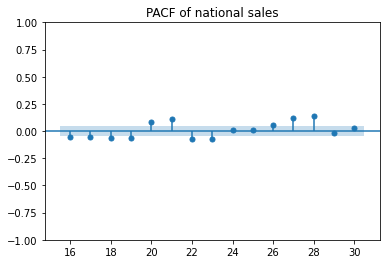

In [ ]:
import  statsmodels.graphics.tsaplots # for partial autocorrelation

ax = statsmodels.graphics.tsaplots.plot_pacf(total_sales_to_scale['scaled_nat_sales'].dropna(), 
                                                 lags=range(16,31),
                                                 title = 'PACF of national sales')

lag 16 - 24 and 27,28 seems good to be used here.

In [ ]:
lags= [16,17,18,19,20,21,22,23,24,27,28]
for lag in lags:
    total_sales_to_scale['nat_scaled_sales_lag{}'.format(lag)] = total_sales_to_scale['scaled_nat_sales'].shift(lag)

In [ ]:
total_sales_to_scale = total_sales_to_scale.drop(['national_sales','scaled_nat_sales'],axis=1) 
#don't think the current sales will be practical in real situation

In [ ]:
total_sales_to_scale.reset_index().tail() #reset index for ease of merge

index  nat_scaled_sales_lag16  nat_scaled_sales_lag17  \
1699 2017-08-27                0.564068                0.444261   
1700 2017-08-28                0.540965                0.564068   
1701 2017-08-29                0.590952                0.540965   
1702 2017-08-30                0.519256                0.590952   
1703 2017-08-31                0.520447                0.519256   

      nat_scaled_sales_lag18  nat_scaled_sales_lag19  nat_scaled_sales_lag20  \
1699                0.500919                0.489709                0.544275   
1700                0.444261                0.500919                0.489709   
1701                0.564068                0.444261                0.500919   
1702                0.540965                0.564068                0.444261   
1703                0.590952                0.540965                0.564068   

      nat_scaled_sales_lag21  nat_scaled_sales_lag22  nat_scaled_sales_lag23  \
1699                0.716875                0.659455                0.565028   
1700                0.544275                0.716875                0.659455   
1701                0.489709                0.544275                0.716875   
1702                0.500919                0.489709                0.544275   
1703                0.444261                0.500919                0.489709   

      nat_scaled_sales_lag24  nat_scaled_sales_lag27  nat_scaled_sales_lag28  
1699                0.496762                0.604794                0.767672  
1700                0.565028                0.675089                0.604794  
1701                0.659455                0.658783                0.675089  
1702                0.716875                0.496762                0.658783  
1703                0.544275                0.565028                0.496762

In [ ]:
inputs = inputs.merge(total_sales_to_scale.reset_index(),how='left',left_on='date',right_on='index')

In [ ]:
del total_sales_to_scale

In [ ]:
inputs.columns #just checking what are in the df

Index(['date', 'store_nbr', 'family', 'id', 'sales', 'onpromotion',
       'store_loc__Ambato', 'store_loc__Babahoyo', 'store_loc__Cayambe',
       'store_loc__Cuenca', 'store_loc__Daule', 'store_loc__El Carmen',
       'store_loc__Esmeraldas', 'store_loc__Guaranda', 'store_loc__Guayaquil',
       'store_loc__Ibarra', 'store_loc__Latacunga', 'store_loc__Libertad',
       'store_loc__Loja', 'store_loc__Machala', 'store_loc__Manta',
       'store_loc__Playas', 'store_loc__Puyo', 'store_loc__Quevedo',
       'store_loc__Quito', 'store_loc__Riobamba', 'store_loc__Salinas',
       'store_loc__Santo Domingo', 'index', 'nat_scaled_sales_lag16',
       'nat_scaled_sales_lag17', 'nat_scaled_sales_lag18',
       'nat_scaled_sales_lag19', 'nat_scaled_sales_lag20',
       'nat_scaled_sales_lag21', 'nat_scaled_sales_lag22',
       'nat_scaled_sales_lag23', 'nat_scaled_sales_lag24',
       'nat_scaled_sales_lag27', 'nat_scaled_sales_lag28'],
      dtype='object')

In [ ]:
inputs.drop(['index'],axis=1,inplace=True) #column named 'index' in dt format don't need it anymore

Now, let's continue on individual store sales lag. From the lag ananyses above, I have conclude that the lags which will be used here are lag = [1 2 3 4 5 6 7 8 13 14]. Let's put it to good use.

In [ ]:
inputs

date  store_nbr                      family       id  sales  \
0       2013-01-01          1                  AUTOMOTIVE        0    0.0   
1       2013-01-01          1                   BABY CARE        1    0.0   
2       2013-01-01          1                      BEAUTY        2    0.0   
3       2013-01-01          1                   BEVERAGES        3    0.0   
4       2013-01-01          1                       BOOKS        4    0.0   
...            ...        ...                         ...      ...    ...   
3029395 2017-08-31          9                     POULTRY  3029395    0.0   
3029396 2017-08-31          9              PREPARED FOODS  3029396    0.0   
3029397 2017-08-31          9                     PRODUCE  3029397    0.0   
3029398 2017-08-31          9  SCHOOL AND OFFICE SUPPLIES  3029398    0.0   
3029399 2017-08-31          9                     SEAFOOD  3029399    0.0   

         onpromotion  store_loc__Ambato  store_loc__Babahoyo  \
0                  0                  0                    0   
1                  0                  0                    0   
2                  0                  0                    0   
3                  0                  0                    0   
4                  0                  0                    0   
...              ...                ...                  ...   
3029395            1                  0                    0   
3029396            0                  0                    0   
3029397            1                  0                    0   
3029398            9                  0                    0   
3029399            0                  0                    0   

         store_loc__Cayambe  store_loc__Cuenca  ...  nat_scaled_sales_lag17  \
0                         0                  0  ...                     NaN   
1                         0                  0  ...                     NaN   
2                         0                  0  ...                     NaN   
3                         0                  0  ...                     NaN   
4                         0                  0  ...                     NaN   
...                     ...                ...  ...                     ...   
3029395                   0                  0  ...                0.519256   
3029396                   0                  0  ...                0.519256   
3029397                   0                  0  ...                0.519256   
3029398                   0                  0  ...                0.519256   
3029399                   0                  0  ...                0.519256   

         nat_scaled_sales_lag18  nat_scaled_sales_lag19  \
0                           NaN                     NaN   
1                           NaN                     NaN   
2                           NaN                     NaN   
3                           NaN                     NaN   
4                           NaN                     NaN   
...                         ...                     ...   
3029395                0.590952                0.540965   
3029396                0.590952                0.540965   
3029397                0.590952                0.540965   
3029398                0.590952                0.540965   
3029399                0.590952                0.540965   

         nat_scaled_sales_lag20  nat_scaled_sales_lag21  \
0                           NaN                     NaN   
1                           NaN                     NaN   
2                           NaN                     NaN   
3                           NaN                     NaN   
4                           NaN                     NaN   
...                         ...                     ...   
3029395                0.564068                0.444261   
3029396                0.564068                0.444261   
3029397                0.564068                0.444261   
3029398                0.564068                0.444261   
3029399      

In [ ]:
lags = [1, 2, 3, 4, 5, 6, 7, 8, 13, 14]
for lag in lags:
    inputs['store_fam_sales_lag_{}'.format(lag)] = inputs['sales'].shift(lag)

In [ ]:
inputs.columns

Index(['date', 'store_nbr', 'family', 'id', 'sales', 'onpromotion',
       'store_loc__Ambato', 'store_loc__Babahoyo', 'store_loc__Cayambe',
       'store_loc__Cuenca', 'store_loc__Daule', 'store_loc__El Carmen',
       'store_loc__Esmeraldas', 'store_loc__Guaranda', 'store_loc__Guayaquil',
       'store_loc__Ibarra', 'store_loc__Latacunga', 'store_loc__Libertad',
       'store_loc__Loja', 'store_loc__Machala', 'store_loc__Manta',
       'store_loc__Playas', 'store_loc__Puyo', 'store_loc__Quevedo',
       'store_loc__Quito', 'store_loc__Riobamba', 'store_loc__Salinas',
       'store_loc__Santo Domingo', 'nat_scaled_sales_lag16',
       'nat_scaled_sales_lag17', 'nat_scaled_sales_lag18',
       'nat_scaled_sales_lag19', 'nat_scaled_sales_lag20',
       'nat_scaled_sales_lag21', 'nat_scaled_sales_lag22',
       'nat_scaled_sales_lag23', 'nat_scaled_sales_lag24',
       'nat_scaled_sales_lag27', 'nat_scaled_sales_lag28',
       'store_fam_sales_lag_1', 'store_fam_sales_lag_2',
       'sto

Now add the transaction lag to the inputs.

In [ ]:
transactions

store_nbr  transactions
date                               
2013-01-01         25           770
2013-01-02          1          2111
2013-01-02          2          2358
2013-01-02          3          3487
2013-01-02          4          1922
...               ...           ...
2017-08-15         50          2804
2017-08-15         51          1573
2017-08-15         52          2255
2017-08-15         53           932
2017-08-15         54           802

[83488 rows x 2 columns]

still left the row from 2017-08-16 to 2017-08-31 and notice that someday, some store won't open (such as new year that we only have store 25. How do I map this to the inputs dataframe?? 

In [ ]:
store_nbr = range(1,55)
dates = pd.date_range('2013-01-01','2017-08-31')
mul_index = pd.MultiIndex.from_product([dates,store_nbr],names=['date','store_nbr'])
df = pd.DataFrame(index=mul_index)

In [ ]:
df.reset_index()

date  store_nbr
0     2013-01-01          1
1     2013-01-01          2
2     2013-01-01          3
3     2013-01-01          4
4     2013-01-01          5
...          ...        ...
92011 2017-08-31         50
92012 2017-08-31         51
92013 2017-08-31         52
92014 2017-08-31         53
92015 2017-08-31         54

[92016 rows x 2 columns]

In [ ]:
transactions.reset_index()

date  store_nbr  transactions
0     2013-01-01         25           770
1     2013-01-02          1          2111
2     2013-01-02          2          2358
3     2013-01-02          3          3487
4     2013-01-02          4          1922
...          ...        ...           ...
83483 2017-08-15         50          2804
83484 2017-08-15         51          1573
83485 2017-08-15         52          2255
83486 2017-08-15         53           932
83487 2017-08-15         54           802

[83488 rows x 3 columns]

In [ ]:
df_transaction = df.reset_index().merge(transactions.reset_index(),
                                        how='left',
                                        left_on=['date','store_nbr'],
                                        right_on=['date','store_nbr']
                                       )

In [ ]:
df_transaction.fillna(0, inplace=True)

In [ ]:
df_transaction.loc[30020:30026] #just checking

date  store_nbr  transactions
30020 2014-07-10         51        1552.0
30021 2014-07-10         52           0.0
30022 2014-07-10         53         657.0
30023 2014-07-10         54         750.0
30024 2014-07-11          1        1802.0
30025 2014-07-11          2        1962.0
30026 2014-07-11          3        3138.0

In [ ]:
#df_transaction.rename(columns={'level_0':'date','level_1':'store_nbr'}, inplace = True)

In [ ]:
df_transaction

date  store_nbr  transactions
0     2013-01-01          1           0.0
1     2013-01-01          2           0.0
2     2013-01-01          3           0.0
3     2013-01-01          4           0.0
4     2013-01-01          5           0.0
...          ...        ...           ...
92011 2017-08-31         50           0.0
92012 2017-08-31         51           0.0
92013 2017-08-31         52           0.0
92014 2017-08-31         53           0.0
92015 2017-08-31         54           0.0

[92016 rows x 3 columns]

Now adding the lag. Remember the meaningful lag for transaction are lag = [21,22,28]

In [ ]:
lags = [21,22,28]
for lag in lags:
    df_transaction['trans_lag_{}'.format(lag)] = df_transaction['transactions'].shift(lag)

In [ ]:
df_transaction = df_transaction.drop('transactions',axis=1) #in real life daily transaction came after day's end

In [ ]:
df_transaction = df_transaction.fillna(0)

In [ ]:
df_transaction.loc[30030:30040] #ust checking

date  store_nbr  trans_lag_21  trans_lag_22  trans_lag_28
30030 2014-07-11          7        1207.0        1348.0        1019.0
30031 2014-07-11          8         888.0        1207.0        2279.0
30032 2014-07-11          9           0.0         888.0         593.0
30033 2014-07-11         10        1209.0           0.0         947.0
30034 2014-07-11         11        3780.0        1209.0        1551.0
30035 2014-07-11         12        3143.0        3780.0        1477.0
30036 2014-07-11         13        3018.0        3143.0        1348.0
30037 2014-07-11         14        3312.0        3018.0        1207.0
30038 2014-07-11         15        2471.0        3312.0         888.0
30039 2014-07-11         16        2219.0        2471.0           0.0
30040 2014-07-11         17        2407.0        2219.0        1209.0

Next, merge the df_transaction to the inputs df.

In [ ]:
inputs

date  store_nbr                      family       id  sales  \
0       2013-01-01          1                  AUTOMOTIVE        0    0.0   
1       2013-01-01          1                   BABY CARE        1    0.0   
2       2013-01-01          1                      BEAUTY        2    0.0   
3       2013-01-01          1                   BEVERAGES        3    0.0   
4       2013-01-01          1                       BOOKS        4    0.0   
...            ...        ...                         ...      ...    ...   
3029395 2017-08-31          9                     POULTRY  3029395    0.0   
3029396 2017-08-31          9              PREPARED FOODS  3029396    0.0   
3029397 2017-08-31          9                     PRODUCE  3029397    0.0   
3029398 2017-08-31          9  SCHOOL AND OFFICE SUPPLIES  3029398    0.0   
3029399 2017-08-31          9                     SEAFOOD  3029399    0.0   

         onpromotion  store_loc__Ambato  store_loc__Babahoyo  \
0                  0                  0                    0   
1                  0                  0                    0   
2                  0                  0                    0   
3                  0                  0                    0   
4                  0                  0                    0   
...              ...                ...                  ...   
3029395            1                  0                    0   
3029396            0                  0                    0   
3029397            1                  0                    0   
3029398            9                  0                    0   
3029399            0                  0                    0   

         store_loc__Cayambe  store_loc__Cuenca  ...  store_fam_sales_lag_1  \
0                         0                  0  ...                    NaN   
1                         0                  0  ...                    0.0   
2                         0                  0  ...                    0.0   
3                         0                  0  ...                    0.0   
4                         0                  0  ...                    0.0   
...                     ...                ...  ...                    ...   
3029395                   0                  0  ...                    0.0   
3029396                   0                  0  ...                    0.0   
3029397                   0                  0  ...                    0.0   
3029398                   0                  0  ...                    0.0   
3029399                   0                  0  ...                    0.0   

         store_fam_sales_lag_2  store_fam_sales_lag_3  store_fam_sales_lag_4  \
0                          NaN                    NaN                    NaN   
1                          NaN                    NaN                    NaN   
2                          0.0                    NaN                    NaN   
3                          0.0                    0.0                    NaN   
4                          0.0                    0.0                    0.0   
...                        ...                    ...                    ...   
3029395                    0.0                    0.0                    0.0   
3029396                    0.0                    0.0                    0.0   
3029397                    0.0                    0.0                    0.0   
3029398                    0.0                    0.0                    0.0   
3029399                    0.0                    0.0                    0.0   

         store_fam_sales_lag_5  store_fam_sales_lag_6  store_fam_sales_lag_7  \
0                          NaN                    NaN                    NaN   
1                          NaN                    NaN                    NaN   
2                          NaN                    NaN                    NaN   
3                          NaN                    NaN                    NaN   
4                     

In [ ]:
inputs = inputs.merge(df_transaction, how='left', left_on = ['date','store_nbr'],right_on = ['date','store_nbr'])

In [ ]:
inputs

date  store_nbr                      family       id  sales  \
0       2013-01-01          1                  AUTOMOTIVE        0    0.0   
1       2013-01-01          1                   BABY CARE        1    0.0   
2       2013-01-01          1                      BEAUTY        2    0.0   
3       2013-01-01          1                   BEVERAGES        3    0.0   
4       2013-01-01          1                       BOOKS        4    0.0   
...            ...        ...                         ...      ...    ...   
3029395 2017-08-31          9                     POULTRY  3029395    0.0   
3029396 2017-08-31          9              PREPARED FOODS  3029396    0.0   
3029397 2017-08-31          9                     PRODUCE  3029397    0.0   
3029398 2017-08-31          9  SCHOOL AND OFFICE SUPPLIES  3029398    0.0   
3029399 2017-08-31          9                     SEAFOOD  3029399    0.0   

         onpromotion  store_loc__Ambato  store_loc__Babahoyo  \
0                  0                  0                    0   
1                  0                  0                    0   
2                  0                  0                    0   
3                  0                  0                    0   
4                  0                  0                    0   
...              ...                ...                  ...   
3029395            1                  0                    0   
3029396            0                  0                    0   
3029397            1                  0                    0   
3029398            9                  0                    0   
3029399            0                  0                    0   

         store_loc__Cayambe  store_loc__Cuenca  ...  store_fam_sales_lag_4  \
0                         0                  0  ...                    NaN   
1                         0                  0  ...                    NaN   
2                         0                  0  ...                    NaN   
3                         0                  0  ...                    NaN   
4                         0                  0  ...                    0.0   
...                     ...                ...  ...                    ...   
3029395                   0                  0  ...                    0.0   
3029396                   0                  0  ...                    0.0   
3029397                   0                  0  ...                    0.0   
3029398                   0                  0  ...                    0.0   
3029399                   0                  0  ...                    0.0   

         store_fam_sales_lag_5  store_fam_sales_lag_6  store_fam_sales_lag_7  \
0                          NaN                    NaN                    NaN   
1                          NaN                    NaN                    NaN   
2                          NaN                    NaN                    NaN   
3                          NaN                    NaN                    NaN   
4                          NaN                    NaN                    NaN   
...                        ...                    ...                    ...   
3029395                    0.0                    0.0                    0.0   
3029396                    0.0                    0.0                    0.0   
3029397                    0.0                    0.0                    0.0   
3029398                    0.0                    0.0                    0.0   
3029399                    0.0                    0.0                    0.0   

         store_fam_sales_lag_8  store_fam_sales_lag_13  \
0                          NaN                     NaN   
1                          NaN                     NaN   
2                          NaN                     NaN   
3                          NaN                     NaN   
4                          NaN                     NaN   
...                        ...                     ...   
3029395         

Next, add the holiday features into the inputs DF

In [ ]:
calendar_checkpoint.reset_index().tail()

index  holiday__Ambato  holiday__Cayambe  holiday__Cotopaxi  \
1699 2017-08-27                0                 0                  0   
1700 2017-08-28                0                 0                  0   
1701 2017-08-29                0                 0                  0   
1702 2017-08-30                0                 0                  0   
1703 2017-08-31                0                 0                  0   

      holiday__Cuenca  holiday__Ecuador  holiday__El Carmen  \
1699                0                 0                   0   
1700                0                 0                   0   
1701                0                 0                   0   
1702                0                 0                   0   
1703                0                 0                   0   

      holiday__Esmeraldas  holiday__Guaranda  holiday__Guayaquil  ...  \
1699                    0                  0                   0  ...   
1700                    0                  0                   0  ...   
1701                    0                  0                   0  ...   
1702                    0                  0                   0  ...   
1703                    0                  0                   0  ...   

      holiday__Santa Elena  holiday__Santo Domingo  \
1699                     0                       0   
1700                     0                       0   
1701                     0                       0   
1702                     0                       0   
1703                     0                       0   

      holiday__Santo Domingo de los Tsachilas  transferred  dow  workday  \
1699                                        0            0    7        0   
1700                                        0            0    1        1   
1701                                        0            0    2        1   
1702                                        0            0    3        1   
1703                                        0            0    4        1   

      is_football  is_eq  is_ny  is_christmas  
1699            0      0      0             0  
1700            0      0      0             0  
1701            0      0      0             0  
1702            0      0      0             0  
1703            0      0      0             0  

[5 rows x 32 columns]

In [ ]:
inputs = inputs.merge(calendar_checkpoint,how='left',left_on=['date'],right_on=calendar_checkpoint.index)

In [ ]:
inputs.columns

Index(['date', 'store_nbr', 'family', 'id', 'sales', 'onpromotion',
       'store_loc__Ambato', 'store_loc__Babahoyo', 'store_loc__Cayambe',
       'store_loc__Cuenca', 'store_loc__Daule', 'store_loc__El Carmen',
       'store_loc__Esmeraldas', 'store_loc__Guaranda', 'store_loc__Guayaquil',
       'store_loc__Ibarra', 'store_loc__Latacunga', 'store_loc__Libertad',
       'store_loc__Loja', 'store_loc__Machala', 'store_loc__Manta',
       'store_loc__Playas', 'store_loc__Puyo', 'store_loc__Quevedo',
       'store_loc__Quito', 'store_loc__Riobamba', 'store_loc__Salinas',
       'store_loc__Santo Domingo', 'nat_scaled_sales_lag16',
       'nat_scaled_sales_lag17', 'nat_scaled_sales_lag18',
       'nat_scaled_sales_lag19', 'nat_scaled_sales_lag20',
       'nat_scaled_sales_lag21', 'nat_scaled_sales_lag22',
       'nat_scaled_sales_lag23', 'nat_scaled_sales_lag24',
       'nat_scaled_sales_lag27', 'nat_scaled_sales_lag28',
       'store_fam_sales_lag_1', 'store_fam_sales_lag_2',
       'sto

let's check for missing data.

In [ ]:
pd.set_option('display.max_rows',None)
inputs.isna().sum()

date                                           0
store_nbr                                      0
family                                         0
id                                             0
sales                                          0
onpromotion                                    0
store_loc__Ambato                              0
store_loc__Babahoyo                            0
store_loc__Cayambe                             0
store_loc__Cuenca                              0
store_loc__Daule                               0
store_loc__El Carmen                           0
store_loc__Esmeraldas                          0
store_loc__Guaranda                            0
store_loc__Guayaquil                           0
store_loc__Ibarra                              0
store_loc__Latacunga                           0
store_loc__Libertad                            0
store_loc__Loja                                0
store_loc__Machala                             0
store_loc__Manta    

In [ ]:
pd.reset_option('display.max_rows','display.max_columns')

Drop all the NaN (which are all lagging features)

In [ ]:
inputs.dropna(inplace = True)
inputs.isna().sum().sum()

0

In [ ]:
inputs = inputs.set_index('date')

In [ ]:
inputs.tail()

store_nbr                      family       id  sales  \
date                                                                
2017-08-31          9                     POULTRY  3029395    0.0   
2017-08-31          9              PREPARED FOODS  3029396    0.0   
2017-08-31          9                     PRODUCE  3029397    0.0   
2017-08-31          9  SCHOOL AND OFFICE SUPPLIES  3029398    0.0   
2017-08-31          9                     SEAFOOD  3029399    0.0   

            onpromotion  store_loc__Ambato  store_loc__Babahoyo  \
date                                                              
2017-08-31            1                  0                    0   
2017-08-31            0                  0                    0   
2017-08-31            1                  0                    0   
2017-08-31            9                  0                    0   
2017-08-31            0                  0                    0   

            store_loc__Cayambe  store_loc__Cuenca  store_loc__Daule  ...  \
date                                                                 ...   
2017-08-31                   0                  0                 0  ...   
2017-08-31                   0                  0                 0  ...   
2017-08-31                   0                  0                 0  ...   
2017-08-31                   0                  0                 0  ...   
2017-08-31                   0                  0                 0  ...   

            holiday__Santa Elena  holiday__Santo Domingo  \
date                                                       
2017-08-31                     0                       0   
2017-08-31                     0                       0   
2017-08-31                     0                       0   
2017-08-31                     0                       0   
2017-08-31                     0                       0   

            holiday__Santo Domingo de los Tsachilas  transferred  dow  \
date                                                                    
2017-08-31                                        0            0    4   
2017-08-31                                        0            0    4   
2017-08-31                                        0            0    4   
2017-08-31                                        0            0    4   
2017-08-31                                        0            0    4   

            workday  is_football  is_eq  is_ny  is_christmas  
date                                                          
2017-08-31        1            0      0      0             0  
2017-08-31        1            0      0      0             0  
2017-08-31        1            0      0      0             0  
2017-08-31        1            0      0      0             0  
2017-08-31        1            0      0      0             0  

[5 rows x 82 columns]

From all the features list I planned to use.
* Sales lag ---- DONE
* Total daily sales lag Across the country ---- DONE
* The amount of the promotion for that product family ---- DONE
* Store Area (to be crossed with the locale name of holiday) ---- DONE
* Features from Holiday ---- DONE
    * type ---- DONE
    * locale name ---- DONE
    * day of week ---- DONE
    * is_worlday ---- DONE
    * Earthquake ---- DONE
    * Football ---- DONE
    * New Year ---- DONE
    * shopping events (such as Black Friday) ---- DONE
* Daily Transaction Lag for each shop ---- DONE

Let's make the training data and testing data.

In [ ]:
y_train = inputs.loc['2013-01-01':'2017-08-15', 'sales']
y_train.tail()

date
2017-08-15     438.133
2017-08-15     154.553
2017-08-15    2419.729
2017-08-15     121.000
2017-08-15      16.000
Name: sales, dtype: float64

In [ ]:
x_train = inputs.loc['2013-01-01':'2017-08-15'].drop(['sales','id'],axis=1)
x_train = x_train.reset_index()
x_train = x_train.set_index(['date','store_nbr','family'])


In [ ]:
x_train.tail()

onpromotion  \
date       store_nbr family                                    
2017-08-15 9         POULTRY                               0   
                     PREPARED FOODS                        1   
                     PRODUCE                             148   
                     SCHOOL AND OFFICE SUPPLIES            8   
                     SEAFOOD                               0   

                                                 store_loc__Ambato  \
date       store_nbr family                                          
2017-08-15 9         POULTRY                                     0   
                     PREPARED FOODS                              0   
                     PRODUCE                                     0   
                     SCHOOL AND OFFICE SUPPLIES                  0   
                     SEAFOOD                                     0   

                                                 store_loc__Babahoyo  \
date       store_nbr family                                            
2017-08-15 9         POULTRY                                       0   
                     PREPARED FOODS                                0   
                     PRODUCE                                       0   
                     SCHOOL AND OFFICE SUPPLIES                    0   
                     SEAFOOD                                       0   

                                                 store_loc__Cayambe  \
date       store_nbr family                                           
2017-08-15 9         POULTRY                                      0   
                     PREPARED FOODS                               0   
                     PRODUCE                                      0   
                     SCHOOL AND OFFICE SUPPLIES                   0   
                     SEAFOOD                                      0   

                                                 store_loc__Cuenca  \
date       store_nbr family                                          
2017-08-15 9         POULTRY                                     0   
                     PREPARED FOODS                              0   
                     PRODUCE                                     0   
                     SCHOOL AND OFFICE SUPPLIES                  0   
                     SEAFOOD                                     0   

                                                 store_loc__Daule  \
date       store_nbr family                                         
2017-08-15 9         POULTRY                                    0   
                     PREPARED FOODS                             0   
                     PRODUCE                                    0   
                     SCHOOL AND OFFICE SUPPLIES                 0   
                     SEAFOOD                                    0   

                                                 store_loc__El Carmen  \
date       store_nbr family                                             
2017-08-15 9         POULTRY                                        0   
                     PREPARED FOODS                                 0   
                     PRODUCE                                        0   
                     SCHOOL AND OFFICE SUPPLIES                     0   
                     SEAFOOD                                        0   

                                                 store_loc__Esmeraldas  \
date       store_nbr family                                              
2017-08-15 9         POULTRY                                         0   
                     PREPARED FOODS                                  0   
                     PRODUCE                                         0   
                     SCHOOL AND OFFICE SUPPLIES                      0   
                     SEAFOOD                                         0   

                                                 store_loc__Guaranda  \
date       store_nbr family 

In [ ]:
x_train.describe()

onpromotion  store_loc__Ambato  store_loc__Babahoyo  \
count  2.872584e+06       2.872584e+06         2.872584e+06   
mean   2.650192e+00       3.703704e-02         1.851852e-02   
std    1.234626e+01       1.888526e-01         1.348169e-01   
min    0.000000e+00       0.000000e+00         0.000000e+00   
25%    0.000000e+00       0.000000e+00         0.000000e+00   
50%    0.000000e+00       0.000000e+00         0.000000e+00   
75%    0.000000e+00       0.000000e+00         0.000000e+00   
max    7.410000e+02       1.000000e+00         1.000000e+00   

       store_loc__Cayambe  store_loc__Cuenca  store_loc__Daule  \
count        2.872584e+06       2.872584e+06      2.872584e+06   
mean         1.851852e-02       5.555556e-02      1.851852e-02   
std          1.348169e-01       2.290615e-01      1.348169e-01   
min          0.000000e+00       0.000000e+00      0.000000e+00   
25%          0.000000e+00       0.000000e+00      0.000000e+00   
50%          0.000000e+00       0.000000e+00      0.000000e+00   
75%          0.000000e+00       0.000000e+00      0.000000e+00   
max          1.000000e+00       1.000000e+00      1.000000e+00   

       store_loc__El Carmen  store_loc__Esmeraldas  store_loc__Guaranda  \
count          2.872584e+06           2.872584e+06         2.872584e+06   
mean           1.851852e-02           1.851852e-02         1.851852e-02   
std            1.348169e-01           1.348169e-01         1.348169e-01   
min            0.000000e+00           0.000000e+00         0.000000e+00   
25%            0.000000e+00           0.000000e+00         0.000000e+00   
50%            0.000000e+00           0.000000e+00         0.000000e+00   
75%            0.000000e+00           0.000000e+00         0.000000e+00   
max            1.000000e+00           1.000000e+00         1.000000e+00   

       store_loc__Guayaquil  ...  holiday__Santa Elena  \
count          2.872584e+06  ...          2.872584e+06   
mean           1.481481e-01  ...          2.481390e-03   
std            3.552468e-01  ...          4.975172e-02   
min            0.000000e+00  ...          0.000000e+00   
25%            0.000000e+00  ...          0.000000e+00   
50%            0.000000e+00  ...          0.000000e+00   
75%            0.000000e+00  ...          0.000000e+00   
max            1.000000e+00  ...          1.000000e+00   

       holiday__Santo Domingo  holiday__Santo Domingo de los Tsachilas  \
count               2872584.0                             2.872584e+06   
mean                      0.0                             2.481390e-03   
std                       0.0                             4.975172e-02   
min                       0.0                             0.000000e+00   
25%                       0.0                             0.000000e+00   
50%                       0.0                             0.000000e+00   
75%                       0.0                             0.000000e+00   
max                       0.0                             1.000000e+00   

        transferred           dow       workday   is_football         is_eq  \
count  2.872584e+06  2.872584e+06  2.872584e+06  2.872584e+06  2.872584e+06   
mean   4.962779e-03  3.992556e+00  6.830025e-01  8.684864e-03  1.799007e-02   
std    7.027198e-02  2.001227e+00  4.653065e-01  9.278707e-02  1.329152e-01   
min    0.000000e+00  1.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    0.000000e+00  2.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
50%    0.000000e+00  4.000000e+00  1.000000e+00  0.000000e+00  0.000000e+00   
75%    0.000000e+00  6.000000e+00  1.000000e+00  0.000000e+00  0.000000e+00   
max    1.000000e+00  7.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   

              is_ny  is_christmas  
count  2.872584e+06     2872584.0  
mean   2.481390e-03           0.0  
std    4.975172e-02           0.0  
min    0.000000e+00           0.0  
25%    0.000000e+00           0.0  
50%    0.000000e+00           0.0  
75%    0.000000

In [ ]:
x_test = inputs.loc['2017-08-16': ]
test_id = x_test['id'] #Keep for later

x_test.drop(['sales','id'],axis = 1,inplace = True)

x_test = x_test.reset_index()
x_test = x_test.set_index(['date','store_nbr','family'])
x_test

onpromotion  \
date       store_nbr family                                    
2017-08-16 1         AUTOMOTIVE                            0   
                     BABY CARE                             0   
                     BEAUTY                                2   
                     BEVERAGES                            20   
                     BOOKS                                 0   
...                                                      ...   
2017-08-31 9         POULTRY                               1   
                     PREPARED FOODS                        0   
                     PRODUCE                               1   
                     SCHOOL AND OFFICE SUPPLIES            9   
                     SEAFOOD                               0   

                                                 store_loc__Ambato  \
date       store_nbr family                                          
2017-08-16 1         AUTOMOTIVE                                  0   
                     BABY CARE                                   0   
                     BEAUTY                                      0   
                     BEVERAGES                                   0   
                     BOOKS                                       0   
...                                                            ...   
2017-08-31 9         POULTRY                                     0   
                     PREPARED FOODS                              0   
                     PRODUCE                                     0   
                     SCHOOL AND OFFICE SUPPLIES                  0   
                     SEAFOOD                                     0   

                                                 store_loc__Babahoyo  \
date       store_nbr family                                            
2017-08-16 1         AUTOMOTIVE                                    0   
                     BABY CARE                                     0   
                     BEAUTY                                        0   
                     BEVERAGES                                     0   
                     BOOKS                                         0   
...                                                              ...   
2017-08-31 9         POULTRY                                       0   
                     PREPARED FOODS                                0   
                     PRODUCE                                       0   
                     SCHOOL AND OFFICE SUPPLIES                    0   
                     SEAFOOD                                       0   

                                                 store_loc__Cayambe  \
date       store_nbr family                                           
2017-08-16 1         AUTOMOTIVE                                   0   
                     BABY CARE                                    0   
                     BEAUTY                                       0   
                     BEVERAGES                                    0   
                     BOOKS                                        0   
...                                                             ...   
2017-08-31 9         POULTRY                                      0   
                     PREPARED FOODS                               0   
                     PRODUCE                                      0   
                     SCHOOL AND OFFICE SUPPLIES                   0   
                     SEAFOOD                                      0   

                                                 store_loc__Cuenca  \
date       store_nbr family                                          
2017-08-16 1         AUTOMOTIVE                                  0   
                     BABY CARE                                   0   
                     BEAUTY                                      0   
                     BEVERAGES                                   0   
                     BOO

# 6. Built model(s) and Validate model(s)

I am going to be using the XGBoost Regressor to predict the sales for this model.

### Let's do it.

In [ ]:
from xgboost import XGBRegressor
xgb = XGBRegressor(max_depth=2, learning_rate=0.1, n_estimators=100, objective='reg:squarederror', booster='gbtree')
xgb.fit(x_train,y_train) 

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=2, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [ ]:
y_pred = xgb.predict(x_test)

# 7. Test the models and Submission

Since this is a regression prediction, I think I won't need a validation data. I will just measure the model by the score.

In [ ]:
len(y_pred)

28512

prepare the submission.

First, make sure that the id are matched between the train data and y_pred.

In [ ]:
sample

id  sales
0      3000888    0.0
1      3000889    0.0
2      3000890    0.0
3      3000891    0.0
4      3000892    0.0
...        ...    ...
28507  3029395    0.0
28508  3029396    0.0
28509  3029397    0.0
28510  3029398    0.0
28511  3029399    0.0

[28512 rows x 2 columns]

In [ ]:
test_id 

date
2017-08-16    3000888
2017-08-16    3000889
2017-08-16    3000890
2017-08-16    3000891
2017-08-16    3000892
               ...   
2017-08-31    3029395
2017-08-31    3029396
2017-08-31    3029397
2017-08-31    3029398
2017-08-31    3029399
Name: id, Length: 28512, dtype: int64

The id are matched. Let's submit

In [ ]:
sample['sales'] = y_pred
sample

id        sales
0      3000888   149.837112
1      3000889   260.570862
2      3000890   797.142395
3      3000891  1976.599731
4      3000892   -36.433578
...        ...          ...
28507  3029395   300.662476
28508  3029396   107.792099
28509  3029397   300.662476
28510  3029398   943.954102
28511  3029399   107.792099

[28512 rows x 2 columns]

In [ ]:
# The actual submission
sample.to_csv('submission.csv', index = False) # Submit

# 8. Problems Notes

These are the notes I plan to use in the next iteration of this project or others. I plan to do this project as a freely unguide - simple project to see what would happen if I want to try time series with some crude skills and knowledge. I hope that, as I keep going, I will develop better understanding and more mastery. I hope that this note book in the next next iteration will be better and more robust.


### Problems
1. Need more coding, statistic and ML mastery to fully tackle the problem 
    * -> Practicing
2. Still Have no idea how to deal with the different selling patterns between different Product Families.
    * -> Some great notebooks are dealing with this by using more complicated models. I will try to understand them.
3. I feel like the Oil price must be beneficial for training the model. Just don't know how to utilize it.
    * -> Explore more idea from other notebooks
4. Need more practice using Pandas snd Matplotlib.
5. Sometimes I'm not sure how to impliment the insight from the EDA into the model.
6. Lacking of project planning experience seems to cost me a lot of time fixing and refixing the code and also the procedure. For example, I had construct the holiday dummy table just to find that I need to to the entire formatting and dummying again in the main calendar DF since the Holiday DF are note date complete.
    * -> I guess this is how the lesson is learned
7. Memory leak: I was writing code without thinking about the memory leak. This is really bad practice and the first time I got it in ML. This stall my entire process and need to be fix right away.
    * -> Concern more 
    * -> I Google and found this great [notebook](https://www.kaggle.com/pavansanagapati/14-simple-tips-to-save-ram-memory-for-1-gb-dataset/comments). Upvoted.
        * simpler methods I think I'm gonna use here in this notebook are:
            * Free Memory using gc.collect()
            * Datatype Conversions¶ (for convert dummy or categorical data into category using data.astype('category')
            * Dealing with memory leak by using in-function variable (which will be cleared after the function done executing.
    * When merging BIG dataframes, it might be better for limited memory to convert the bigger one in to csv at a managable chunk using chunksize= pharameter.
    * Still, due to my lake of experience the DF structure in have in mind still won't work. It got over 4M rows. Need to fix immediately.


# 9. Conclusion

In [ ]:
result = x_test
result['predicted_sales'] = y_pred
result = result['predicted_sales'].groupby(['date','store_nbr']).sum()

result

date        store_nbr
2017-08-16  1            20219.113281
            2            20799.355469
            3            22864.013672
            4            20234.234375
            5            13876.207031
                             ...     
2017-08-31  50            9237.862305
            51            7194.880371
            52            7677.529785
            53            6683.934082
            54            7301.814941
Name: predicted_sales, Length: 864, dtype: float32

In [ ]:
result = result.unstack()

pd.set_option('display.max_columns',None)
result

store_nbr             1             2             3             4   \
date                                                                 
2017-08-16  20219.113281  20799.355469  22864.013672  20234.234375   
2017-08-17  12368.041016  12491.448242  13561.602539  12415.962891   
2017-08-18  16812.271484  18227.484375  18518.330078  16818.689453   
2017-08-19  14422.850586  14667.344727  16155.054688  14667.344727   
2017-08-20  14030.756836  15100.296875  16279.132812  14691.672852   
2017-08-21  12811.544922  13174.745117  12333.968750  11865.525391   
2017-08-22  12281.858398  12718.395508  13894.450195  12030.572266   
2017-08-23  16291.637695  16345.485352  17413.833984  15654.844727   
2017-08-24  11927.237305  12483.147461  13945.367188  11406.948242   
2017-08-25  16404.845703  17308.617188  18532.798828  16767.093750   
2017-08-26  15029.366211  15902.686523  16320.044922  14973.988281   
2017-08-27  12933.167969  15587.390625  17282.103516  15372.035156   
2017-08-28  11041.175781  12011.321289  13318.412109  11184.754883   
2017-08-29  12897.217773  13727.788086  14127.853516  13467.900391   
2017-08-30  16778.474609  16532.263672  17917.732422  15734.066406   
2017-08-31  13149.990234  12731.873047  13671.124023  12630.511719   

store_nbr             5             6             7             8   \
date                                                                 
2017-08-16  13876.207031  20718.816406  21735.201172  20717.615234   
2017-08-17   7970.548340  13353.183594   3750.009766   3750.009766   
2017-08-18  11444.464844  18236.804688  17914.792969  17082.148438   
2017-08-19  10049.641602  15732.853516  15522.760742  15719.035156   
2017-08-20   9513.095703  16040.407227  16127.064453  15854.267578   
2017-08-21   7379.875977  12628.784180  13218.935547  13430.582031   
2017-08-22   7785.209961  12879.954102  13083.455078  13983.397461   
2017-08-23   9286.657227  17071.632812  17657.992188  17114.677734   
2017-08-24   7180.650879  13245.072266  12642.389648  13206.388672   
2017-08-25  10355.551758  16945.980469  17443.468750  17441.281250   
2017-08-26   9153.690430  16044.894531  14917.953125  15763.036133   
2017-08-27  10359.337891  17145.277344  16540.130859  16602.037109   
2017-08-28   7596.805176  13413.139648  12219.150391  13413.139648   
2017-08-29   8166.992676  13196.680664  13879.135742   3891.263184   
2017-08-30  10452.943359  17376.519531  17096.660156  17044.332031   
2017-08-31   6852.101562  13143.785156  12443.348633  13172.535156   

store_nbr             9             10            11            12  \
date                                                                 
2017-08-16  20610.312500  21184.195312  14743.299805  14463.501953   
2017-08-17  14477.463867  11554.783203   9201.129883   8382.796875   
2017-08-18  15910.324219  13281.974609  10032.824219   8633.276367   
2017-08-19  17964.742188  14920.497070  12017.263672  11076.401367   
2017-08-20  19140.367188  14724.305664  12244.501953  11127.060547   
2017-08-21  14311.060547  11400.463867   8957.042969   8666.032227   
2017-08-22  16684.109375  11979.292969   9936.610352   9285.577148   
2017-08-23  15575.877930  12002.168945   9176.808594   8325.507812   
2017-08-24  14458.712891  11840.969727   8390.584961   7922.090332   
2017-08-25  15264.121094  12372.943359  10124.655273   8036.551758   
2017-08-26  18430.839844  14245.282227  12201.826172  10922.187500   
2017-08-27  18035.705078  14696.469727  12597.880859  10725.193359   
2017-08-28  13370.306641  11289.687500   8609.501953   7311.826172   
2017-08-29  16186.696289  12515.589844  10162.907227   9549.369141   
2017-08-30  14931.784180  29681.785156   9208.682617   7916.247070   
2017-08-31  14251.008789  12609.079102   8597.352539   7186.899902   

store_nbr             13            14            15            16  \
date                                                                 
2017-08-16  14414.384766  15481.497070  15534.920898  15811.673828   
2017-08

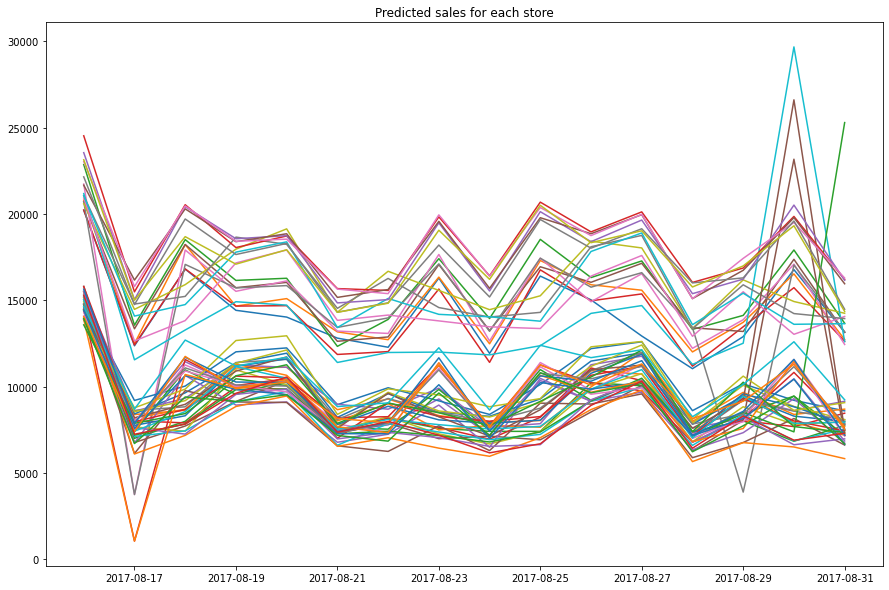

In [ ]:
fig, ax = plt.subplots(figsize = (15,10))
plt.plot(result)
plt.title('Predicted sales for each store')
plt.show()

Too bad. each store follow the same pattern since I use only one model to predict each store. Few (store 10 16 33 36) has high peak during the last days. I wonder what do thay have in common? let's dig deeper

# 10. What could have done better? + Idea for the next iteration.

This is what I have in mind after the first run. I would be very appreciated to all suggestion in the discussion panel. 

1. I forgot to include the insight that some store don't sell some product. Those combination sales could be set to zero flat.
2. Removing the store locations from the inputs might be a good idea. (Perhaps Check the colinearity between all the features)
3. Perhaps, each store should have the model trained individually since different store has different sales pattern, therefore, diffenet weight characteristics.
4. Take in account only the holiday from the main operating area (Quito City) and national holiday
5. Instead of dropna for many lag feature, maybe I should fill_na with zero to preserve the observation.
6. Try scale the onpromotion too
7. Dummy the DOW variable.
8. Try using MA instead of lag feature
9. Using Pipeline in the data processing
10. Using Sliding windows technique for training.

# 11. Footnote

It's been a really daunting task for a first-timer like me just to do this from the beginning to the submission. For this simple-educational competition, and using only the linear regression model, It took me many more days than I expected. However, after the submission, I felt really happy that I had finally finised the first attempt.

The score I got is **3.44178**, which, is noting less than an "abysmal" just like the level I expected to have compared to the **0.5xx** from the Kaggle Course. Still, I'm very happy about the process and what I've learn from practicing with this notebook.

The code here, I'm sure, must be very scrappy, but for the next iteration with more experience and more complicated model (I'm thinking about DeterministicProcess(), Fourier Combination, Forest etc.), I hope to produce better result and better understanding of data science.

For Kaggle and everyone that read through my notebook, thank you.